In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from imblearn.metrics import geometric_mean_score
from metrics import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from dataset import *
from utils import *
from models import *

# 1. cov-abdab

## 1.1 EDA

current：GT 抗体-抗原
- 输入抗原，复现/重构抗体
- diff？

refineGNN
- framework
- CDR H3

current：MEAN
- 输入：离CDR H1~H3最近的48个AA + 轻链 + framework
- 生成：CDR H1/H2/H3

ideal：输入抗原chain（no sturcture） asdsbdjkasdkjsah
- 生成抗体

ideal：输入抗原链
- 找epitope
- 根据epitope设计paratope（CDR）= generation + docking
- 根据CDR完善补全整条抗体链

In [3]:
data = pd.read_csv("../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv")
data

,Index,AB_name,Class,Paratope,Epitope
0,1,m396,0,SYTWGGITILIANYQRDTVMGGSKWDSSDY,FSTFRGDEVRNNGQPTYGVGYQY
1,2,80R,0,SYAVISYDRDRSYDRVRSNDSTRSGSGSDFTTSRSW,RDVGGYNLYLFKGFNCYFLQSYGQPTYGVYQ
2,3,F26G19,0,YVSYTTYRYPGNDTTTEGIPQL,AFSTGDRWNNNPTYGVGYQY
3,4,1AF10,0,NWRENRYDPYYAMDIQHYQQTDSWPT,FIVKNKCVFTGVLTDIATDLDITPCSFGGSYQGVNRAGCIG
4,5,6D3,1,WHEDDYINYEYGLLAQNNFYTY,NVFAEHVNNSS
...,...,...,...,...,...
305,306,scFv_E4,1,VSGVTSSNYYPGGSYRDLSEKDVIQGISYSGQNS,RDQTGNDYYLFRKSNYQAGSTFNYFPLQSYGYGVGY
306,307,N3113,1,YEALEWSYHSRTYNPSWASGSTGDW,VATRFASYAWNKSKGGNYNYLRITEINGVKFLQS
307,308,N3113.1,1,QWYSRYNPSWASGST,ATRFASYANKDKVGNYNYLYITEINGVKFPLQSYG
308,309,RBD-chAb-15,1,GHWTTWGGSTNGYYV,YASFSTFKRGDRAWNTYGVGYQPY


In [4]:
len1 = []
len2 = []

for i in range(data.shape[0]):
    len1.append(len(data["Paratope"].iloc[i]))
    len2.append(len(data["Epitope"].iloc[i]))
    
np.mean(len1), np.std(len1), np.max(len1), np.min(len1)

(24.767741935483873, 7.183600817667714, 60, 2)

In [5]:
np.mean(len2), np.std(len2), np.max(len2), np.min(len2)

(24.738709677419354, 9.685678733502161, 75, 4)

(array([  3.,  14.,  53., 105.,  74.,  47.,  12.,   1.,   0.,   1.]),
 array([ 2. ,  7.8, 13.6, 19.4, 25.2, 31. , 36.8, 42.6, 48.4, 54.2, 60. ]),
 <BarContainer object of 10 artists>)

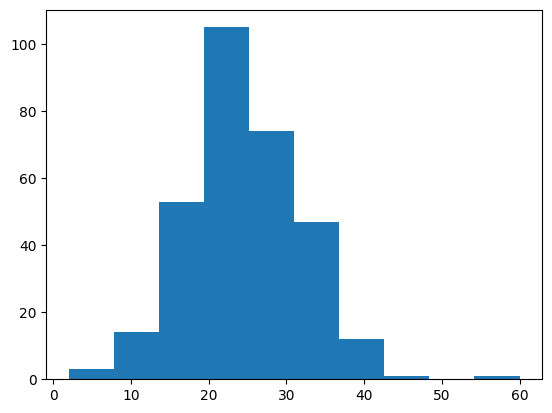

In [6]:
plt.hist(len1)

In [7]:
max(len1)

60

(array([ 21.,  54., 112.,  69.,  36.,  12.,   2.,   1.,   2.,   1.]),
 array([ 4. , 11.1, 18.2, 25.3, 32.4, 39.5, 46.6, 53.7, 60.8, 67.9, 75. ]),
 <BarContainer object of 10 artists>)

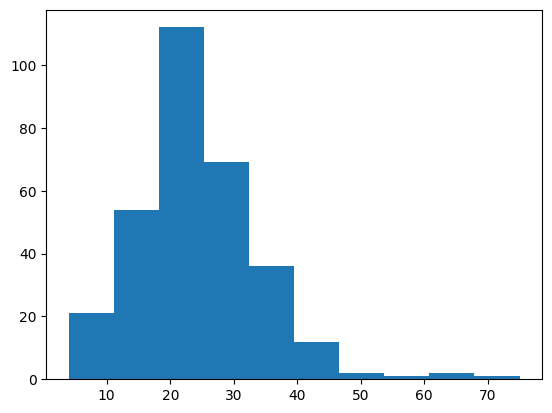

In [8]:
plt.hist(len2)

In [9]:
max(len2)

75

<AxesSubplot:>

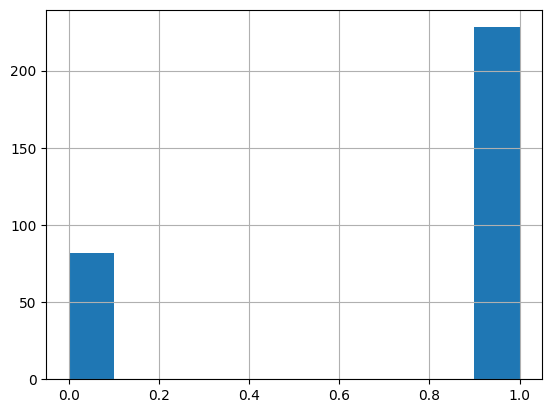

In [10]:
data["Class"].hist()

In [11]:
len(data["Paratope"].unique())

310

In [12]:
len(data["Epitope"].unique())

306

# Fine-tuning

In [14]:
set_seed(seed=3407)

In [15]:
clip_norm = 1

# model name
# model_name = "demo"
model_name = "masonscnn"
# model_name = "lstm"

# model_name = "InteractTransformer"
# model_name = "InteractCoAttnTransformer"

# model_name = "InteractTransformerLSTM"

# model_name = "SetTransformer"
# model_name = "SetCoAttnTransformer"

# model_name = "SetModel"
# model_name = "SetCoAttnModel"
# model_name = "SetModel_ablation"

# model_name = "FTransformer"

# model_name = "EnsembleModel"
# model_name = "PESI"

# use_fine_tune = True
use_fine_tune = False

# fix_FE = True
fix_FE = False

# use_pair = True
use_pair = False

if use_fine_tune==True:
    model_name += "_ft"

    if use_pair==True:
        model_name += "_pairPreTrain"
        
# 0 - L2; 1 - L1
use_reg = 0

# use_BSS = True
use_BSS = False

os.makedirs("./results/CoV-AbDab/{}/".format(model_name), exist_ok=True)

print("model name: {}".format(model_name))

kfold_labels = []
kfold_preds = []

for k_iter in range(10):
    
    print("=========================================================")
    print("fold {} as val set".format(k_iter))
    
    train_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                               kfold=10, holdout_fold=k_iter, is_train_test_full="train", \
                               use_pair=False, balance_samples=False)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False, \
                                               collate_fn=my_collate_fn2)

    test_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                              kfold=10, holdout_fold=k_iter, is_train_test_full="test", \
                              use_pair=False, balance_samples=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, \
                                               collate_fn=my_collate_fn1)

    if model_name=="demo":
        model = BiLSTM_demo(embed_size=32, hidden=64, num_layers=1, dropout=0.5, use_pretrain=False).cuda()
        
        epochs = 100
        lr = 6e-5
        
    elif model_name=="masonscnn":
        model = MasonsCNN(amino_ft_dim=len(vocab), 
                          max_antibody_len=100, 
                          max_virus_len=100, 
                          h_dim=512, 
                          dropout=0.1).cuda()
        epochs = 100
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="masonscnn_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/masonscnn/model_best.pth")

        if fix_FE==True:
            for name, param in model.cnnmodule.named_parameters():
                param.requires_grad = False
            for name, param in model.cnnmodule2.named_parameters():
                param.requires_grad = False


        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="masonscnn_ft_pairPreTrain":
        
        encoder = torch.load("./results/SAbDab/full/seq1_neg0/masonscnn_encoder/model_best.pth")
        model = TowerBaseModel(embed_size=32, hidden=128, encoder=encoder, 
                               use_two_towers=False, use_coattn=False, fusion=0).cuda()
        
        if fix_FE==True:
            for name, param in model.encoder.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4

    elif model_name=="lstm":
        model = BiLSTM(embed_size=32, 
                       hidden=64, 
                       num_layers=1, 
                       dropout=0.5, 
                       use_pretrain=False).cuda()

        epochs = 300
        lr = 1e-4
        l2_coef = 5e-4

    elif model_name=="lstm_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/lstm/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.LSTM_para.named_parameters():
                param.requires_grad = False
            for name, param in model.LSTM_epi.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="lstm_ft_pairPreTrain":

        encoder = torch.load("./results/SAbDab/full/seq1_neg0/lstm_encoder/model_best.pth")
        encoder.train()
        model = TowerBaseModel(embed_size=64, hidden=128, encoder=encoder, 
                               use_two_towers=False, use_coattn=False, fusion=1).cuda()
        
        if fix_FE==True:
            for name, param in model.encoder.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
    
    elif model_name=="InteractTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.3, 
                                    use_coattn=False).cuda()
        epochs = 200
        lr = 3e-5
        
    elif model_name=="InteractTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.transformer_para.named_parameters():
                param.requires_grad = False
            for name, param in model.transformer_epi.named_parameters():
                param.requires_grad = False

        epochs = 1000
        lr = 1e-4
        l2_coef = 5e-4
                
    elif model_name=="InteractCoAttnTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.5, 
                                    use_coattn=True).cuda()
        epochs = 200
        lr = 3e-5
        
    elif model_name=="InteractCoAttnTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractCoAttnTransformer/model_best.pth")
        model.train()
    
        if fix_FE==True:
            for name, param in model.transformer_para.named_parameters():
                param.requires_grad = False
            for name, param in model.transformer_epi.named_parameters():
                param.requires_grad = False
        
        epochs = 1500
        lr = 6e-5
        l2_coef = 5e-4
        
    elif model_name=="InteractCoAttnTransformer_ft_pairPreTrain":
        encoder = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformer_encoder/model_best.pth")
        encoder.train()
        
        model = TowerBaseModel(embed_size=32, hidden=128, encoder=encoder, 
                               use_two_towers=False, use_coattn=True, fusion=1).cuda()
    
        if fix_FE==True:
            for name, param in model.encoder.named_parameters():
                param.requires_grad = False
        
        epochs = 1500
        lr = 6e-5
        l2_coef = 5e-4

    elif model_name=="InteractTransformerLSTM":
        model = InteractTransformerLSTM(embed_size=32, 
                                        hidden=64, 
                                        num_encoder_layers=1, 
                                        num_lstm_layers=1, 
                                        nhead=2, 
                                        dropout=0.5, 
                                        use_coattn=True).cuda()
        epochs = 200
        lr = 6e-5

    elif model_name=="InteractTransformerLSTM_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformerLSTM/model_best.pth")
        model.train()
        
        epochs = 200
        lr = 6e-5
                
    elif model_name=="SetTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=False, 
                               share=False).cuda()
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="SetTransformer_ft":

        model = torch.load("./results/SAbDab/full/seq1_neg0/SetTransformer/model_best.pth")
        model.train()

        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False

        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
        
    elif model_name=="SetCoAttnTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=True).cuda()
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4
        
    elif model_name=="SetCoAttnTransformer_ft":
        if use_BSS==False:
#             model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnTransformer/model_best.pth")
#             model.train()

#             if fix_FE==True:
#                 for name, param in model.para_enc.named_parameters():
#                     param.requires_grad = False
#                 for name, param in model.para_dec.named_parameters():
#                     param.requires_grad = False
#                 for name, param in model.epi_enc.named_parameters():
#                     param.requires_grad = False
#                 for name, param in model.epi_dec.named_parameters():
#                     param.requires_grad = False
            
#             epochs = 500
#             lr = 3e-5
#             l2_coef = 6e-4
            model = SetTransformer(dim_input=32, 
                                   num_outputs=32, 
                                   dim_output=32, 
                                   dim_hidden=64, 
                                   num_inds=6, 
                                   num_heads=4, 
                                   ln=True, 
                                   dropout=0.5, 
                                   use_coattn=False, 
                                   share=False, 
                                   use_BSS=False).cuda()
        
            pt_model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnTransformer/model_best.pth")
        
            model.para_enc = pt_model.para_enc
            model.para_dec = pt_model.para_dec
            model.epi_enc = pt_model.epi_enc
            model.epi_dec = pt_model.epi_dec
            model.train()
        
            epochs = 500
            lr = 6e-5
            l2_coef = 5e-4

        elif use_BSS==True:
            print(model_name, use_BSS)
            model = SetTransformer(dim_input=32, 
                                   num_outputs=32, 
                                   dim_output=32, 
                                   dim_hidden=64, 
                                   num_inds=6, 
                                   num_heads=4, 
                                   ln=True, 
                                   dropout=0.5, 
                                   use_coattn=False, 
                                   share=False, 
                                   use_BSS=True).cuda()
        
            # load pre-trained weights
            pt_model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnTransformer/model_best.pth")
        
            model.embedding = pt_model.embedding
            
            model.para_enc = pt_model.para_enc
            model.epi_enc = pt_model.epi_enc
            
            model.co_attn = pt_model.co_attn
            
            model.para_dec = pt_model.para_dec
            model.epi_dec = pt_model.epi_dec
            
            model.output_layer = pt_model.output_layer
            
            model.train()
        
            # params
            epochs = 500
            lr = 6e-5
            l2_coef = 5e-4
        else:
            print("wrong use_BSS!")
            quit()
        
        
    elif model_name=="SetCoAttnTransformer_ft_pairPreTrain":
        
        encoder = torch.load("./results/SAbDab/full/seq1_neg0/SetTransformer_encoder/model_best.pth")
        encoder.train()
        model = TowerBaseModel(embed_size=32, hidden=128, encoder=encoder, use_two_towers=False, mid_coattn=True, use_coattn=True, fusion=1).cuda()
        
        if fix_FE==True:
            for name, param in model.encoder.named_parameters():
                param.requires_grad = False
        
        epochs = 1500
        lr = 1e-4 #6e-5
        l2_coef = 3e-4 #5e-4
        
        
    elif model_name=="SetModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
        
    elif model_name=="SetModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetModel/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
    
    elif model_name=="SetCoAttnModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=True, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 200
        lr = 3e-5
    
    elif model_name=="SetCoAttnModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnModel/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
        
    elif model_name=="SetModel_ablation":
        model = SetModel_ablation(embed_size=32, 
                         hidden=64, 
                         num_layers=2, 
                         dropout=0.5, 
                         k4kmer=7, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         use_kmer_embed=True, 
                         use_seq_encoder=False, 
                         seq_encoder_type="lstm", 
                         num_heads=4, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 150
        lr = 6e-5
        
    elif model_name=="FTransformer":
        model = FTransformer(embed_size=32, 
                             hidden=64, 
                             num_layers=2, 
                             dropout=0.5, 
                             k4kmer=3, 
                             use_pretrain=False, 
                             use_coattn=True, 
                             seq_encoder_type="transformer", 
                             num_heads=2).cuda()
        
        epochs = 100
        lr = 3e-5
        
    elif model_name=="EnsembleModel":
        model = EnsembleModel(embed_size=16, 
                      hidden=64, 
                      max_len=100, 
                      num_encoder_layers=1, 
                      num_heads=2, 
                      num_inds=6, 
                      num_outputs=6, 
                      ln=True, 
                      dropout=0.5, 
                      use_coattn=True).cuda()
        
        epochs = 500
        lr = 1e-5
        
    elif model_name=="EnsembleModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/EnsembleModel/model_best.pth")
        model.train()
        
        epochs = 500
        lr = 1e-4
        
    elif model_name=="PESI":
#         model = PESI(embed_size=7, 
#                      hidden=512, 
#                      max_len=100, 
#                      num_heads=2, 
#                      num_inds=6, 
#                      num_outputs=6, 
#                      ln=True, 
#                      dropout=0.5, 
#                      use_coattn=True).cuda()
        model = PESI(embed_size=8, 
                     hidden=64, 
                     max_len=100, 
                     num_heads=2, 
                     num_inds=6, 
                     num_outputs=6, 
                     ln=True, 
                     dropout=0.5, 
                     use_coattn=True).cuda()
        
        epochs = 200
        lr = 5e-5
#         wd = 3e-4
        l2_coef = 5e-4
        
    elif model_name=="PESI_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/PESI/model_best.pth")
        model.train()
        
        # freeze frame feature extractor
        for name, param in model.Frame_para.named_parameters():
            param.requires_grad = False
        for name, param in model.Frame_epi.named_parameters():
            param.requires_grad = False
            
        # freeze frame feature extractor        
        for name, param in model.Set_para.named_parameters():
            param.requires_grad = False
        for name, param in model.Set_epi.named_parameters():
            param.requires_grad = False
        
        epochs = 500
        lr = 3e-5
        l2_coef = 5e-4

    else:
        print("wrong model name!!!")
        break

    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)#, weight_decay=wd)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6, last_epoch=-1)

    loss_buf = []
    val_loss_buf = []
    val_acc_buf = []
    val_f1_buf = []
    val_auc_buf = []
    val_gmean_buf = []
    val_mcc_buf = []
    best_val_loss = float("inf")
    
    for epoch in range(epochs):

        loss_tmp = []
        for i, (para, epi, label) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()

            if use_BSS==False:
                pred = model(para, epi)
            elif use_BSS==True:
                pred, BSS = model(para, epi)
            else:
                pass
                
            loss = criterion(pred.view(-1), label.view(-1).cuda())
            
            if use_reg==0:
                param_l2_loss = 0
                for name, param in model.named_parameters():
                    if 'bias' not in name:
                        param_l2_loss += torch.norm(param, p=2)
                param_l2_loss = l2_coef * param_l2_loss
                loss += param_l2_loss
            elif use_reg==1:
                param_l1_loss = 0
                for name, param in model.named_parameters():
                    if 'bias' not in name:
                        param_l1_loss += torch.norm(param, p=1)
                param_l1_loss = l1_coef * param_l1_loss
                loss += param_l1_loss
            else:
                print("wrong use_reg! only 0 or 1!")
                exit()
            
            if use_BSS==True:
                loss += 0.001*BSS

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

            optimizer.step()

            loss_tmp.append(loss.item())
        
        loss_buf.append(np.mean(loss_tmp))

    #     scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])

        with torch.no_grad():

            model.eval()

            preds = []
            labels = []
            val_loss_tmp = []
            for i, (para, epi, label) in enumerate(test_loader):
                if use_BSS==False:
                    pred = model(para, epi)
                elif use_BSS==True:
                    pred, BSS = model(para, epi)
                
                val_loss = criterion(pred.view(-1), label.view(-1).cuda())
                
                if use_BSS==True:
                    val_loss += 0.001*BSS
                
                preds.append(pred.detach().cpu().view(-1))
                labels.append(label.view(-1))
                val_loss_tmp.append(val_loss.item())
            
            preds = torch.stack(preds, axis=1).view(-1)
            labels = torch.stack(labels, axis=1).view(-1)

#             acc = accuracy_score(y_true=labels, y_pred=torch.round(preds))
#             f1 = f1_score(y_true=labels, y_pred=torch.round(preds))
#             auc = roc_auc_score(y_true=labels, y_score=preds)

            acc, f1, auc, gmean, mcc = evaluate_metrics(pred_proba=preds, label=labels)

            val_acc_buf.append(acc)
            val_f1_buf.append(f1)
            val_auc_buf.append(auc)
            val_gmean_buf.append(gmean)
            val_mcc_buf.append(mcc)
            val_loss_buf.append(np.mean(val_loss_tmp))

            print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f} \n Val Acc\t{:.4f} \n Val F1\t\t{:.4f} \n Val AUC\t{:.4f} \n Val GMean\t{:.4f} \n Val MCC\t{:.4f}".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf), acc, f1, auc, gmean, mcc))
            
            if np.mean(val_loss_tmp)<best_val_loss:
                best_val_loss = np.mean(val_loss_tmp)
                torch.save(model, "./results/CoV-AbDab/{}/model_{}_best.pth".format(model_name, k_iter))
                np.save("./results/CoV-AbDab/{}/val_acc_{}_best.npy".format(model_name, k_iter), acc)
                np.save("./results/CoV-AbDab/{}/val_f1_{}_best.npy".format(model_name, k_iter), f1)
                np.save("./results/CoV-AbDab/{}/val_auc_{}_best.npy".format(model_name, k_iter), auc)
                np.save("./results/CoV-AbDab/{}/val_gmean_{}_best.npy".format(model_name, k_iter), gmean)
                np.save("./results/CoV-AbDab/{}/val_mcc_{}_best.npy".format(model_name, k_iter), mcc)

        model.train()
    
    torch.save(model, "./results/CoV-AbDab/{}/model_{}.pth".format(model_name, k_iter))
    np.save("./results/CoV-AbDab/{}/loss_buf_{}.npy".format(model_name, k_iter), np.array(loss_buf))
    np.save("./results/CoV-AbDab/{}/val_loss_buf_{}.npy".format(model_name, k_iter), np.array(val_loss_buf))
    np.save("./results/CoV-AbDab/{}/val_acc_buf_{}.npy".format(model_name, k_iter), np.array(val_acc_buf))
    np.save("./results/CoV-AbDab/{}/val_f1_buf_{}.npy".format(model_name, k_iter), np.array(val_f1_buf))
    np.save("./results/CoV-AbDab/{}/val_auc_buf_{}.npy".format(model_name, k_iter), np.array(val_auc_buf))
    np.save("./results/CoV-AbDab/{}/val_gmean_buf_{}.npy".format(model_name, k_iter), np.array(val_gmean_buf))
    np.save("./results/CoV-AbDab/{}/val_mcc_buf_{}.npy".format(model_name, k_iter), np.array(val_mcc_buf))
    
    
    kfold_labels.append(labels)
    kfold_preds.append(preds)
    
#     break

model name: masonscnn
fold 0 as val set
model parameters:  418817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.76it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.6127 
 Val Loss	0.6368 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.86it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.5975 
 Val Loss	0.6388 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.36it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.5927 
 Val Loss	0.6375 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4524 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 118.67it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.5899 
 Val Loss	0.6367 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4381 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 111.83it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.5879 
 Val Loss	0.6365 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.89it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.5864 
 Val Loss	0.6364 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4429 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.22it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.5852 
 Val Loss	0.6363 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 114.74it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.5841 
 Val Loss	0.6364 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.43it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.5832 
 Val Loss	0.6364 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4190 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.86it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.5823 
 Val Loss	0.6365 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.61it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.5815 
 Val Loss	0.6367 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4095 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.69it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.5806 
 Val Loss	0.6369 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4048 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.23it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.5797 
 Val Loss	0.6372 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4095 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.94it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.5788 
 Val Loss	0.6375 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4048 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.14it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.5779 
 Val Loss	0.6380 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3905 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.17it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.5771 
 Val Loss	0.6385 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3905 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.43it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.5762 
 Val Loss	0.6391 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 119.43it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.5753 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.17it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.5744 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3905 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.34it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.5735 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.47it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.5725 
 Val Loss	0.6422 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3905 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.99it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.5714 
 Val Loss	0.6432 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.31it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.5704 
 Val Loss	0.6442 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.04it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.5692 
 Val Loss	0.6453 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.49it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.5679 
 Val Loss	0.6465 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.52it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.5667 
 Val Loss	0.6477 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.40it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.5654 
 Val Loss	0.6490 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3619 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.21it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.5641 
 Val Loss	0.6504 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.22it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.5628 
 Val Loss	0.6517 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.90it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.5614 
 Val Loss	0.6532 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3571 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.23it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.5599 
 Val Loss	0.6546 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.82it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.5584 
 Val Loss	0.6562 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.94it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.5569 
 Val Loss	0.6578 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.79it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.5554 
 Val Loss	0.6593 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.10it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.5539 
 Val Loss	0.6610 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.41it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.5520 
 Val Loss	0.6626 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.68it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.5502 
 Val Loss	0.6642 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.80it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.5486 
 Val Loss	0.6659 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 116.10it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.5465 
 Val Loss	0.6676 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.3857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 119.39it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.5443 
 Val Loss	0.6693 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 124.96it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.5426 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4048 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.16it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.5406 
 Val Loss	0.6727 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4048 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.10it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.5384 
 Val Loss	0.6744 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.98it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.5364 
 Val Loss	0.6762 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3952 
 Val GMean	0.3086 
 Val MCC	0.0997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.58it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.5343 
 Val Loss	0.6780 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4000 
 Val GMean	0.3162 
 Val MCC	0.2646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 120.84it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.5323 
 Val Loss	0.6797 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3952 
 Val GMean	0.3086 
 Val MCC	0.0997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.45it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.5301 
 Val Loss	0.6814 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3952 
 Val GMean	0.3086 
 Val MCC	0.0997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.56it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.5281 
 Val Loss	0.6833 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.3905 
 Val GMean	0.3162 
 Val MCC	0.2646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.19it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.5258 
 Val Loss	0.6849 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4000 
 Val GMean	0.3086 
 Val MCC	0.0997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 116.14it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.5235 
 Val Loss	0.6865 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4048 
 Val GMean	0.3086 
 Val MCC	0.0997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.58it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.5211 
 Val Loss	0.6881 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4048 
 Val GMean	0.3162 
 Val MCC	0.2646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.24it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.5189 
 Val Loss	0.6897 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4048 
 Val GMean	0.3162 
 Val MCC	0.2646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.61it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.5164 
 Val Loss	0.6914 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4000 
 Val GMean	0.3162 
 Val MCC	0.2646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.72it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.5140 
 Val Loss	0.6929 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4000 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.61it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.5114 
 Val Loss	0.6945 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3952 
 Val GMean	0.3086 
 Val MCC	0.0997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.33it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.5087 
 Val Loss	0.6963 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.3905 
 Val GMean	0.3162 
 Val MCC	0.2646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.22it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.5059 
 Val Loss	0.6978 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.3905 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.50it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.5034 
 Val Loss	0.6993 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3905 
 Val GMean	0.2760 
 Val MCC	-0.1634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 119.37it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.5007 
 Val Loss	0.7010 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3905 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 121.25it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.4982 
 Val Loss	0.7029 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3905 
 Val GMean	0.3086 
 Val MCC	0.0997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 117.84it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.4960 
 Val Loss	0.7046 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3952 
 Val GMean	0.3086 
 Val MCC	0.0997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 121.88it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.4937 
 Val Loss	0.7062 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3952 
 Val GMean	0.3086 
 Val MCC	0.0997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 114.64it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.4914 
 Val Loss	0.7080 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4000 
 Val GMean	0.3086 
 Val MCC	0.0997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.14it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.4887 
 Val Loss	0.7095 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4095 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.40it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.4861 
 Val Loss	0.7110 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4190 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.36it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.4836 
 Val Loss	0.7125 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4238 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.08it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.4812 
 Val Loss	0.7140 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4190 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 122.87it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.4790 
 Val Loss	0.7157 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4190 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.67it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.4766 
 Val Loss	0.7173 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4095 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 124.04it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.4742 
 Val Loss	0.7189 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4095 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 120.55it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.4723 
 Val Loss	0.7205 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4048 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.81it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.4698 
 Val Loss	0.7220 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4095 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.55it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.4677 
 Val Loss	0.7237 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4190 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.04it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.4653 
 Val Loss	0.7252 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4286 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.38it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.4629 
 Val Loss	0.7266 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4333 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.67it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.4604 
 Val Loss	0.7282 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4286 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.90it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.4582 
 Val Loss	0.7298 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4333 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.26it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.4560 
 Val Loss	0.7315 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4190 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.46it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.4538 
 Val Loss	0.7332 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4333 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.01it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.4516 
 Val Loss	0.7350 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4333 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.90it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.4493 
 Val Loss	0.7366 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4286 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.16it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.4474 
 Val Loss	0.7383 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4238 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.97it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.4451 
 Val Loss	0.7402 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4333 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.14it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.4430 
 Val Loss	0.7419 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4286 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.02it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.4409 
 Val Loss	0.7436 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4286 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.32it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.4389 
 Val Loss	0.7453 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4238 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.73it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.4369 
 Val Loss	0.7471 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4286 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.80it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.4348 
 Val Loss	0.7492 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4286 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.18it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.4330 
 Val Loss	0.7515 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4286 
 Val GMean	0.3008 
 Val MCC	0.0075


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.18it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.4311 
 Val Loss	0.7534 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4333 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.77it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.4290 
 Val Loss	0.7551 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4524 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.46it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.4267 
 Val Loss	0.7568 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4476 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.25it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.4245 
 Val Loss	0.7586 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4429 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.37it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.4224 
 Val Loss	0.7605 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4476 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.89it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.4207 
 Val Loss	0.7624 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4476 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.48it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.4186 
 Val Loss	0.7643 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4524 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.93it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.4170 
 Val Loss	0.7660 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4476 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.46it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.4147 
 Val Loss	0.7677 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4571 
 Val GMean	0.2845 
 Val MCC	-0.1150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.83it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.4130 
 Val Loss	0.7696 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4571 
 Val GMean	0.2928 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.18it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.4113 
 Val Loss	0.7716 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4571 
 Val GMean	0.2928 
 Val MCC	-0.0598
fold 1 as val set
model parameters:  418817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.55it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.6406 
 Val Loss	0.6539 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.7045 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.51it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.6096 
 Val Loss	0.6642 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6545 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.00it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.5996 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.31it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.5941 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.46it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.5907 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.54it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.5883 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5818 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.71it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.5865 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.43it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.5850 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.69it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.5837 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5591 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.58it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.5825 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5591 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.00it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.5816 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.38it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.5808 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5545 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.21it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.5800 
 Val Loss	0.6661 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5545 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.87it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.5793 
 Val Loss	0.6660 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 124.52it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.5785 
 Val Loss	0.6659 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.46it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.5778 
 Val Loss	0.6658 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5409 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.01it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.5771 
 Val Loss	0.6657 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5409 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.60it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.5764 
 Val Loss	0.6656 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.43it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.5757 
 Val Loss	0.6655 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.58it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.5749 
 Val Loss	0.6654 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5409 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.57it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.5741 
 Val Loss	0.6653 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.96it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.5733 
 Val Loss	0.6653 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5409 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.84it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.5725 
 Val Loss	0.6652 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5409 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.97it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.5717 
 Val Loss	0.6652 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5409 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.68it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.5708 
 Val Loss	0.6651 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.04it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.5700 
 Val Loss	0.6652 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.78it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.5691 
 Val Loss	0.6652 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.40it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.5681 
 Val Loss	0.6652 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.22it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.5671 
 Val Loss	0.6652 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.98it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.5662 
 Val Loss	0.6653 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5409 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.50it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.5651 
 Val Loss	0.6654 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.40it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.5640 
 Val Loss	0.6655 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.24it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.5629 
 Val Loss	0.6656 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.39it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.5618 
 Val Loss	0.6657 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.68it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.5606 
 Val Loss	0.6658 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.12it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.5593 
 Val Loss	0.6660 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.96it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.5581 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.68it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.5568 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.24it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.5556 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.21it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.5542 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.94it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.5527 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.60it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.5514 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.63it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.5499 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.43it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.5482 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.41it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.5467 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.09it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.5451 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.70it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.5433 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.99it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.5414 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.99it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.5394 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.02it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.5375 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.61it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.5354 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.62it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.5334 
 Val Loss	0.6727 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.13it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.5313 
 Val Loss	0.6738 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.59it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.5290 
 Val Loss	0.6750 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5182 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.79it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.5268 
 Val Loss	0.6759 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5182 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.58it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.5248 
 Val Loss	0.6776 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5182 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.65it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.5228 
 Val Loss	0.6788 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.38it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.5206 
 Val Loss	0.6802 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.80it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.5184 
 Val Loss	0.6815 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5045 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.54it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.5159 
 Val Loss	0.6827 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.67it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.5136 
 Val Loss	0.6843 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4955 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.19it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.5110 
 Val Loss	0.6859 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4864 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.11it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.5085 
 Val Loss	0.6878 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4773 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.85it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.5065 
 Val Loss	0.6895 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.63it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.5039 
 Val Loss	0.6915 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.17it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.5016 
 Val Loss	0.6934 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4773 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.56it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.4989 
 Val Loss	0.6954 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.78it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.4964 
 Val Loss	0.6979 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4591 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.68it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.4942 
 Val Loss	0.7003 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.02it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.4921 
 Val Loss	0.7026 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4591 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.09it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.4899 
 Val Loss	0.7047 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4591 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.16it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.4877 
 Val Loss	0.7071 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.70it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.4857 
 Val Loss	0.7097 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4409 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.84it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.4832 
 Val Loss	0.7126 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.43it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.4810 
 Val Loss	0.7152 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.88it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.4790 
 Val Loss	0.7176 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4455 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.87it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.4764 
 Val Loss	0.7205 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.85it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.4743 
 Val Loss	0.7237 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.52it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.4718 
 Val Loss	0.7267 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.10it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.4696 
 Val Loss	0.7296 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4273 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.46it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.4672 
 Val Loss	0.7327 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.63it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.4652 
 Val Loss	0.7354 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4227 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 121.09it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.4629 
 Val Loss	0.7384 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.80it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.4607 
 Val Loss	0.7409 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4273 
 Val GMean	0.0000 
 Val MCC	-0.1948


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.36it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.4583 
 Val Loss	0.7446 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.64it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.4561 
 Val Loss	0.7477 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4182 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.75it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.4540 
 Val Loss	0.7504 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4182 
 Val GMean	0.0000 
 Val MCC	-0.2428


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.65it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.4518 
 Val Loss	0.7536 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4182 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.21it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.4499 
 Val Loss	0.7568 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4182 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.44it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.4476 
 Val Loss	0.7597 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4182 
 Val GMean	0.0000 
 Val MCC	-0.1948


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.39it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.4457 
 Val Loss	0.7637 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4182 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 142.71it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.4438 
 Val Loss	0.7670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.42it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.4419 
 Val Loss	0.7698 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4227 
 Val GMean	0.0000 
 Val MCC	-0.1948


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.14it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.4401 
 Val Loss	0.7736 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.87it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.4381 
 Val Loss	0.7772 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.62it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.4362 
 Val Loss	0.7806 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.75it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.4338 
 Val Loss	0.7845 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.18it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.4320 
 Val Loss	0.7886 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.85it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.4301 
 Val Loss	0.7926 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4091 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.77it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.4280 
 Val Loss	0.7955 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4136 
 Val GMean	0.0000 
 Val MCC	-0.1948
fold 2 as val set
model parameters:  418817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.63it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.6302 
 Val Loss	0.5111 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.34it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.6132 
 Val Loss	0.5068 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6800 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.52it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.6076 
 Val Loss	0.5077 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.25it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.6045 
 Val Loss	0.5089 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5800 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.92it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.6024 
 Val Loss	0.5094 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5733 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 104.45it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.6008 
 Val Loss	0.5097 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5733 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 106.66it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.5995 
 Val Loss	0.5100 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.61it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.5983 
 Val Loss	0.5101 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5533 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.05it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.5973 
 Val Loss	0.5102 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5467 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.16it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.5964 
 Val Loss	0.5103 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.53it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.5955 
 Val Loss	0.5103 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5400 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.37it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.5946 
 Val Loss	0.5104 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.65it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.5938 
 Val Loss	0.5105 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 124.92it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.5930 
 Val Loss	0.5105 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5467 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.04it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.5921 
 Val Loss	0.5106 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5467 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.33it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.5911 
 Val Loss	0.5106 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5467 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.05it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.5901 
 Val Loss	0.5106 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5533 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.10it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.5892 
 Val Loss	0.5106 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5467 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.03it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.5883 
 Val Loss	0.5106 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5467 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.68it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.5873 
 Val Loss	0.5107 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5467 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.74it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.5863 
 Val Loss	0.5108 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.76it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.5852 
 Val Loss	0.5107 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5400 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.17it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.5842 
 Val Loss	0.5108 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.05it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.5830 
 Val Loss	0.5107 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.36it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.5817 
 Val Loss	0.5107 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.45it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.5803 
 Val Loss	0.5106 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5200 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.33it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.5789 
 Val Loss	0.5106 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.84it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.5775 
 Val Loss	0.5106 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.47it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.5760 
 Val Loss	0.5106 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5267 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.64it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.5746 
 Val Loss	0.5106 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5267 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 117.85it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.5732 
 Val Loss	0.5106 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5067 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.51it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.5715 
 Val Loss	0.5106 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5067 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.97it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.5697 
 Val Loss	0.5106 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.78it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.5680 
 Val Loss	0.5107 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.28it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.5663 
 Val Loss	0.5107 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.63it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.5645 
 Val Loss	0.5107 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5067 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.32it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.5628 
 Val Loss	0.5108 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5067 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.13it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.5607 
 Val Loss	0.5109 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4933 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.21it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.5589 
 Val Loss	0.5110 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.24it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.5569 
 Val Loss	0.5111 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4867 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.26it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.5548 
 Val Loss	0.5113 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4800 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.52it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.5526 
 Val Loss	0.5115 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4800 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.35it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.5505 
 Val Loss	0.5118 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.18it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.5480 
 Val Loss	0.5120 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.47it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.5457 
 Val Loss	0.5123 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.55it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.5434 
 Val Loss	0.5125 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4667 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.80it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.5414 
 Val Loss	0.5128 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.03it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.5390 
 Val Loss	0.5133 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4533 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.32it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.5369 
 Val Loss	0.5139 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.58it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.5344 
 Val Loss	0.5144 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4467 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.74it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.5318 
 Val Loss	0.5151 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.12it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.5294 
 Val Loss	0.5158 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.25it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.5269 
 Val Loss	0.5165 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.43it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.5248 
 Val Loss	0.5173 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.80it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.5225 
 Val Loss	0.5182 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.4200 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.20it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.5199 
 Val Loss	0.5194 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.4200 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.48it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.5174 
 Val Loss	0.5202 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.82it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.5149 
 Val Loss	0.5213 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.4267 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.78it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.5124 
 Val Loss	0.5224 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.70it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.5099 
 Val Loss	0.5235 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.39it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.5067 
 Val Loss	0.5245 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.44it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.5038 
 Val Loss	0.5256 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.14it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.5011 
 Val Loss	0.5268 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.43it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.4989 
 Val Loss	0.5280 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.4200 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.13it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.4964 
 Val Loss	0.5292 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 124.37it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.4937 
 Val Loss	0.5305 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.4200 
 Val GMean	0.4000 
 Val MCC	0.2037


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.32it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.4914 
 Val Loss	0.5316 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.87it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.4888 
 Val Loss	0.5331 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4133 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.22it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.4862 
 Val Loss	0.5344 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.74it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.4838 
 Val Loss	0.5357 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3933 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.50it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.4816 
 Val Loss	0.5370 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4067 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.02it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.4793 
 Val Loss	0.5383 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.0894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 124.42it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.4769 
 Val Loss	0.5398 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.93it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.4743 
 Val Loss	0.5413 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4400 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 122.72it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.4718 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4333 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.24it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.4692 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4333 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.12it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.4670 
 Val Loss	0.5461 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.13it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.4649 
 Val Loss	0.5478 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.62it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.4626 
 Val Loss	0.5498 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4333 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.04it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.4604 
 Val Loss	0.5515 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4200 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.10it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.4585 
 Val Loss	0.5533 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4333 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.33it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.4562 
 Val Loss	0.5550 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4333 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.17it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.4538 
 Val Loss	0.5569 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4267 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.38it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.4514 
 Val Loss	0.5588 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.74it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.4491 
 Val Loss	0.5607 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4200 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.78it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.4471 
 Val Loss	0.5625 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4133 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.89it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.4450 
 Val Loss	0.5643 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4267 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.33it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.4428 
 Val Loss	0.5662 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4333 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.39it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.4409 
 Val Loss	0.5681 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4333 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.55it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.4388 
 Val Loss	0.5700 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4400 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.40it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.4365 
 Val Loss	0.5718 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4333 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.00it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.4344 
 Val Loss	0.5738 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4333 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.31it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.4322 
 Val Loss	0.5757 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.4333 
 Val GMean	0.3916 
 Val MCC	0.1158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.34it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.4303 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4400 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.94it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.4281 
 Val Loss	0.5799 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4467 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.58it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.4261 
 Val Loss	0.5818 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.1287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.33it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.4240 
 Val Loss	0.5842 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4267 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.88it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.4220 
 Val Loss	0.5864 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4400 
 Val GMean	0.3830 
 Val MCC	0.0550


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.03it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.4203 
 Val Loss	0.5888 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4333 
 Val GMean	0.3742 
 Val MCC	0.0072


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.91it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.4187 
 Val Loss	0.5911 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4333 
 Val GMean	0.3830 
 Val MCC	0.0550
fold 3 as val set
model parameters:  418817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.92it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.6151 
 Val Loss	0.7619 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4958 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.64it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.5912 
 Val Loss	0.7863 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5336 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.98it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.5835 
 Val Loss	0.7921 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5672 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 122.14it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.5796 
 Val Loss	0.7925 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5966 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.75it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.5771 
 Val Loss	0.7921 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6303 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.33it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.5753 
 Val Loss	0.7919 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6471 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 121.11it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.5738 
 Val Loss	0.7917 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6681 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.12it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.5727 
 Val Loss	0.7915 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6765 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.04it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.5717 
 Val Loss	0.7913 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7059 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 124.92it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.5709 
 Val Loss	0.7911 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7185 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.19it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.5702 
 Val Loss	0.7908 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7101 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 120.90it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.5696 
 Val Loss	0.7904 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.46it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.5690 
 Val Loss	0.7900 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7185 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.69it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.5684 
 Val Loss	0.7897 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.45it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.5677 
 Val Loss	0.7893 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.30it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.5671 
 Val Loss	0.7888 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7185 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 122.64it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.5666 
 Val Loss	0.7882 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7185 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.66it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.5661 
 Val Loss	0.7877 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7269 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.65it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.5656 
 Val Loss	0.7871 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7185 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.94it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.5651 
 Val Loss	0.7864 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 119.95it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.5645 
 Val Loss	0.7858 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7101 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.04it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.5638 
 Val Loss	0.7850 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 120.93it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.5632 
 Val Loss	0.7842 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 112.32it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.5625 
 Val Loss	0.7834 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.53it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.5618 
 Val Loss	0.7826 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.56it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.5609 
 Val Loss	0.7817 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7185 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.26it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.5601 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.63it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.5592 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.84it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.5583 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7185 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.93it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.5573 
 Val Loss	0.7776 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.54it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.5563 
 Val Loss	0.7766 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7311 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.40it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.5552 
 Val Loss	0.7757 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.84it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.5540 
 Val Loss	0.7748 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7185 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.81it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.5526 
 Val Loss	0.7739 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.65it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.5512 
 Val Loss	0.7730 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7185 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.51it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.5498 
 Val Loss	0.7723 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.31it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.5484 
 Val Loss	0.7714 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.96it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.5469 
 Val Loss	0.7708 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7143 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.72it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.5455 
 Val Loss	0.7700 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.7101 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.74it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.5440 
 Val Loss	0.7697 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.93it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.5425 
 Val Loss	0.7692 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6975 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.30it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.5408 
 Val Loss	0.7691 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6975 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.83it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.5392 
 Val Loss	0.7684 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.93it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.5372 
 Val Loss	0.7680 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.91it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.5357 
 Val Loss	0.7677 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6891 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.69it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.5339 
 Val Loss	0.7676 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6891 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.56it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.5318 
 Val Loss	0.7677 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6807 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.90it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.5297 
 Val Loss	0.7677 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6807 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.23it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.5278 
 Val Loss	0.7679 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.6807 
 Val GMean	0.0000 
 Val MCC	-0.1657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.07it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.5259 
 Val Loss	0.7680 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.6807 
 Val GMean	0.0000 
 Val MCC	-0.1657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.12it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.5238 
 Val Loss	0.7682 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.6807 
 Val GMean	0.0000 
 Val MCC	-0.1657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.77it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.5219 
 Val Loss	0.7685 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.6765 
 Val GMean	0.0000 
 Val MCC	-0.1657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.25it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.5198 
 Val Loss	0.7688 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.6765 
 Val GMean	0.0000 
 Val MCC	-0.1657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.56it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.5173 
 Val Loss	0.7692 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6723 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.55it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.5150 
 Val Loss	0.7697 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6555 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.05it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.5125 
 Val Loss	0.7702 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6555 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.46it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.5104 
 Val Loss	0.7710 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6555 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.94it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.5082 
 Val Loss	0.7719 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6681 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.64it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.5055 
 Val Loss	0.7736 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.6429 
 Val GMean	0.0000 
 Val MCC	-0.1657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.54it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.5030 
 Val Loss	0.7744 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6261 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.78it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.5005 
 Val Loss	0.7755 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6303 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.65it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.4982 
 Val Loss	0.7764 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6261 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.97it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.4957 
 Val Loss	0.7778 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6345 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.93it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.4933 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6218 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.76it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.4909 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6176 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.13it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.4886 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6092 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.46it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.4859 
 Val Loss	0.7826 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6134 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.09it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.4834 
 Val Loss	0.7842 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6134 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.19it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.4811 
 Val Loss	0.7855 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6092 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.95it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.4786 
 Val Loss	0.7872 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6176 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.64it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.4761 
 Val Loss	0.7895 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6134 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.02it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.4738 
 Val Loss	0.7907 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6176 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.15it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.4711 
 Val Loss	0.7919 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6134 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.25it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.4687 
 Val Loss	0.7945 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6218 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.41it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.4665 
 Val Loss	0.7963 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6092 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.11it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.4639 
 Val Loss	0.7980 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6050 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.53it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.4617 
 Val Loss	0.8001 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.6008 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.04it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.4593 
 Val Loss	0.8019 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5924 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.45it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.4571 
 Val Loss	0.8046 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5882 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.91it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.4550 
 Val Loss	0.8062 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6008 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.23it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.4523 
 Val Loss	0.8080 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6008 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.19it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.4499 
 Val Loss	0.8106 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5924 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.80it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.4476 
 Val Loss	0.8129 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5798 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.44it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.4454 
 Val Loss	0.8143 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5672 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.20it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.4433 
 Val Loss	0.8164 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5840 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.48it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.4415 
 Val Loss	0.8186 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5630 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.40it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.4391 
 Val Loss	0.8211 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5462 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.16it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.4371 
 Val Loss	0.8232 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5462 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.14it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.4348 
 Val Loss	0.8253 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5462 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.97it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.4328 
 Val Loss	0.8270 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5462 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.41it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.4305 
 Val Loss	0.8304 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5546 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.02it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.4286 
 Val Loss	0.8332 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5462 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.55it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.4264 
 Val Loss	0.8372 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5336 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.04it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.4243 
 Val Loss	0.8391 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5252 
 Val GMean	0.3550 
 Val MCC	0.0374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.35it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.4221 
 Val Loss	0.8418 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5252 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.75it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.4199 
 Val Loss	0.8448 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5378 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.71it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.4179 
 Val Loss	0.8486 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5378 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.98it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.4160 
 Val Loss	0.8524 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5378 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.55it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.4141 
 Val Loss	0.8547 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5378 
 Val GMean	0.2593 
 Val MCC	0.0255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.72it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.4125 
 Val Loss	0.8575 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5546 
 Val GMean	0.2593 
 Val MCC	0.0255
fold 4 as val set
model parameters:  418817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.73it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.6574 
 Val Loss	0.4320 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.4667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.96it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.6337 
 Val Loss	0.4010 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.81it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.6262 
 Val Loss	0.3930 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.49it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.6226 
 Val Loss	0.3919 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.47it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.6201 
 Val Loss	0.3920 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.22it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.6184 
 Val Loss	0.3920 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.99it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.6171 
 Val Loss	0.3922 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.93it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.6160 
 Val Loss	0.3924 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.15it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.6150 
 Val Loss	0.3928 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.44it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.6142 
 Val Loss	0.3932 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.20it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.6134 
 Val Loss	0.3937 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.29it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.6126 
 Val Loss	0.3942 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.33it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.6119 
 Val Loss	0.3947 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.24it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.6112 
 Val Loss	0.3952 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.39it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.6104 
 Val Loss	0.3958 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 113.94it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.6097 
 Val Loss	0.3964 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.69it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.6090 
 Val Loss	0.3971 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.63it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.6081 
 Val Loss	0.3978 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.81it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.6074 
 Val Loss	0.3984 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.66it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.6065 
 Val Loss	0.3989 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 122.67it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.6057 
 Val Loss	0.3994 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.33it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.6047 
 Val Loss	0.4000 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.70it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.6038 
 Val Loss	0.4004 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.91it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.6027 
 Val Loss	0.4009 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.45it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.6016 
 Val Loss	0.4013 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.22it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.6004 
 Val Loss	0.4018 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.20it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.5994 
 Val Loss	0.4020 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.42it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.5982 
 Val Loss	0.4024 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.17it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.5968 
 Val Loss	0.4027 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.10it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.5954 
 Val Loss	0.4030 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.95it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.5940 
 Val Loss	0.4032 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.61it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.5926 
 Val Loss	0.4035 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.89it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.5911 
 Val Loss	0.4036 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.66it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.5895 
 Val Loss	0.4039 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.25it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.5877 
 Val Loss	0.4038 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.56it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.5863 
 Val Loss	0.4037 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.59it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.5848 
 Val Loss	0.4038 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.11it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.5831 
 Val Loss	0.4039 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.25it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.5812 
 Val Loss	0.4045 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.24it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.5792 
 Val Loss	0.4043 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.98it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.5771 
 Val Loss	0.4042 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.70it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.5753 
 Val Loss	0.4047 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.01it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.5730 
 Val Loss	0.4044 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.59it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.5710 
 Val Loss	0.4045 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.96it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.5686 
 Val Loss	0.4043 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.81it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.5662 
 Val Loss	0.4031 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.89it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.5641 
 Val Loss	0.4037 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.09it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.5619 
 Val Loss	0.4036 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.05it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.5597 
 Val Loss	0.4026 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.70it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.5579 
 Val Loss	0.4024 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.85it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.5551 
 Val Loss	0.4027 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.24it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.5527 
 Val Loss	0.4021 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.28it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.5503 
 Val Loss	0.4016 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.78it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.5481 
 Val Loss	0.4012 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.57it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.5453 
 Val Loss	0.4004 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.70it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.5428 
 Val Loss	0.4002 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.13it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.5400 
 Val Loss	0.3995 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.81it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.5375 
 Val Loss	0.3990 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.33it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.5350 
 Val Loss	0.3986 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.09it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.5325 
 Val Loss	0.3979 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.81it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.5298 
 Val Loss	0.3984 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.63it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.5273 
 Val Loss	0.3975 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.22it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.5246 
 Val Loss	0.3968 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.97it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.5224 
 Val Loss	0.3963 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.17it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.5198 
 Val Loss	0.3958 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.56it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.5173 
 Val Loss	0.3952 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.03it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.5147 
 Val Loss	0.3951 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.47it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.5121 
 Val Loss	0.3945 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.42it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.5097 
 Val Loss	0.3939 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.99it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.5069 
 Val Loss	0.3932 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.46it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.5043 
 Val Loss	0.3919 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.32it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.5019 
 Val Loss	0.3912 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.95it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.4992 
 Val Loss	0.3908 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.79it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.4965 
 Val Loss	0.3898 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.03it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.4940 
 Val Loss	0.3895 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.55it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.4917 
 Val Loss	0.3895 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.33it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.4895 
 Val Loss	0.3895 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.83it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.4873 
 Val Loss	0.3893 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.69it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.4848 
 Val Loss	0.3894 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.22it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.4825 
 Val Loss	0.3888 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.60it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.4806 
 Val Loss	0.3885 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.82it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.4781 
 Val Loss	0.3882 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.91it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.4758 
 Val Loss	0.3880 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.79it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.4735 
 Val Loss	0.3877 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.21it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.4713 
 Val Loss	0.3872 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.71it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.4691 
 Val Loss	0.3862 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.01it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.4668 
 Val Loss	0.3853 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.45it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.4646 
 Val Loss	0.3851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.98it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.4625 
 Val Loss	0.3845 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.57it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.4605 
 Val Loss	0.3844 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.88it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.4586 
 Val Loss	0.3842 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.03it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.4567 
 Val Loss	0.3842 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.60it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.4545 
 Val Loss	0.3835 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.58it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.4527 
 Val Loss	0.3831 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 124.44it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.4507 
 Val Loss	0.3836 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.01it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.4486 
 Val Loss	0.3832 
 Val Acc	0.8710 
 Val F1		0.9310 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.79it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.4467 
 Val Loss	0.3823 
 Val Acc	0.9355 
 Val F1		0.9667 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.80it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.4449 
 Val Loss	0.3815 
 Val Acc	0.9032 
 Val F1		0.9492 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.50it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.4431 
 Val Loss	0.3823 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.76it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.4414 
 Val Loss	0.3822 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.0703
fold 5 as val set
model parameters:  418817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.11it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.6258 
 Val Loss	0.5713 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5978 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.58it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.6071 
 Val Loss	0.5706 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5924 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.82it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.6014 
 Val Loss	0.5705 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5707 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.32it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.5984 
 Val Loss	0.5705 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5598 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.32it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.5961 
 Val Loss	0.5707 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.35it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.5945 
 Val Loss	0.5707 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5543 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.11it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.5933 
 Val Loss	0.5708 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5380 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.28it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.5922 
 Val Loss	0.5709 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5272 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.67it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.5913 
 Val Loss	0.5710 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5435 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.16it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.5905 
 Val Loss	0.5711 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5489 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.05it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.5896 
 Val Loss	0.5712 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5380 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.93it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.5889 
 Val Loss	0.5714 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5380 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.88it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.5881 
 Val Loss	0.5716 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5326 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.40it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.5873 
 Val Loss	0.5719 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5272 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.48it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.5866 
 Val Loss	0.5722 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5217 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.60it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.5859 
 Val Loss	0.5725 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5163 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.45it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.5851 
 Val Loss	0.5729 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5163 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.05it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.5842 
 Val Loss	0.5733 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5109 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.40it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.5832 
 Val Loss	0.5738 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5109 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.43it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.5823 
 Val Loss	0.5743 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.35it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.5813 
 Val Loss	0.5749 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.58it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.5803 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.07it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.5791 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.82it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.5780 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.51it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.5767 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.82it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.5757 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5109 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.42it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.5744 
 Val Loss	0.5787 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5109 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.50it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.5731 
 Val Loss	0.5794 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.30it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.5718 
 Val Loss	0.5802 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.10it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.5703 
 Val Loss	0.5809 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.33it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.5688 
 Val Loss	0.5816 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5109 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.56it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.5674 
 Val Loss	0.5822 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.17it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.5661 
 Val Loss	0.5829 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.40it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.5645 
 Val Loss	0.5835 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.03it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.5627 
 Val Loss	0.5842 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.90it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.5611 
 Val Loss	0.5849 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.70it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.5595 
 Val Loss	0.5856 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.16it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.5579 
 Val Loss	0.5863 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.76it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.5561 
 Val Loss	0.5870 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5054 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.93it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.5544 
 Val Loss	0.5878 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.65it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.5526 
 Val Loss	0.5886 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.36it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.5508 
 Val Loss	0.5894 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4837 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.37it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.5489 
 Val Loss	0.5902 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4728 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.26it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.5471 
 Val Loss	0.5911 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4783 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.25it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.5453 
 Val Loss	0.5920 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4837 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.25it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.5432 
 Val Loss	0.5930 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4837 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.43it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.5413 
 Val Loss	0.5939 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4783 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.16it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.5393 
 Val Loss	0.5947 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4783 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.89it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.5376 
 Val Loss	0.5956 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4728 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.33it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.5354 
 Val Loss	0.5965 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4783 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.13it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.5335 
 Val Loss	0.5975 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.30it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.5314 
 Val Loss	0.5984 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.34it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.5293 
 Val Loss	0.5994 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.58it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.5272 
 Val Loss	0.6004 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5109 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.94it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.5251 
 Val Loss	0.6014 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.13it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.5232 
 Val Loss	0.6025 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.17it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.5212 
 Val Loss	0.6035 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4837 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.12it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.5191 
 Val Loss	0.6045 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.31it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.5168 
 Val Loss	0.6056 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4783 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.78it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.5147 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4837 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.66it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.5125 
 Val Loss	0.6079 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.50it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.5103 
 Val Loss	0.6090 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.54it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.5083 
 Val Loss	0.6102 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.41it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.5058 
 Val Loss	0.6115 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.82it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.5039 
 Val Loss	0.6127 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.74it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.5020 
 Val Loss	0.6141 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.08it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.5000 
 Val Loss	0.6153 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.15it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.4979 
 Val Loss	0.6167 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.51it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.4958 
 Val Loss	0.6180 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.14it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.4938 
 Val Loss	0.6193 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.97it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.4914 
 Val Loss	0.6208 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.95it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.4893 
 Val Loss	0.6222 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4946 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.58it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.4874 
 Val Loss	0.6237 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4728 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.75it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.4852 
 Val Loss	0.6253 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4728 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.23it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.4831 
 Val Loss	0.6267 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4620 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.87it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.4810 
 Val Loss	0.6283 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4674 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.78it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.4790 
 Val Loss	0.6302 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4620 
 Val GMean	0.0000 
 Val MCC	-0.1077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.14it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.4767 
 Val Loss	0.6317 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4620 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.56it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.4746 
 Val Loss	0.6334 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4783 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.26it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.4726 
 Val Loss	0.6353 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4783 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.71it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.4702 
 Val Loss	0.6369 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4728 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.36it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.4681 
 Val Loss	0.6387 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4728 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.67it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.4662 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4783 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.61it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.4643 
 Val Loss	0.6424 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4728 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.45it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.4624 
 Val Loss	0.6446 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4783 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.90it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.4606 
 Val Loss	0.6463 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.54it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.4586 
 Val Loss	0.6481 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.36it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.4566 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.58it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.4543 
 Val Loss	0.6517 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.08it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.4524 
 Val Loss	0.6539 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.28it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.4508 
 Val Loss	0.6555 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4946 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.51it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.4488 
 Val Loss	0.6575 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.89it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.4474 
 Val Loss	0.6595 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5109 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.59it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.4455 
 Val Loss	0.6613 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5054 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.89it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.4436 
 Val Loss	0.6630 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5054 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.03it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.4420 
 Val Loss	0.6650 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5109 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.49it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.4405 
 Val Loss	0.6667 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5109 
 Val GMean	0.3378 
 Val MCC	0.0563


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.39it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.4387 
 Val Loss	0.6686 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5109 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.49it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.4370 
 Val Loss	0.6706 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5109 
 Val GMean	0.0000 
 Val MCC	-0.1549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.01it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.4351 
 Val Loss	0.6725 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5109 
 Val GMean	0.0000 
 Val MCC	-0.1549
fold 6 as val set
model parameters:  418817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.10it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.6210 
 Val Loss	0.4734 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6769 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.57it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.6104 
 Val Loss	0.4723 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.02it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.6069 
 Val Loss	0.4759 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7154 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.13it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.6048 
 Val Loss	0.4778 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7154 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.35it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.6029 
 Val Loss	0.4786 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7231 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.10it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.6014 
 Val Loss	0.4791 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7231 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.01it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.6001 
 Val Loss	0.4796 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7231 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.69it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.5991 
 Val Loss	0.4801 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7231 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.25it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.5982 
 Val Loss	0.4804 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7154 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.67it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.5973 
 Val Loss	0.4806 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7308 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.88it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.5965 
 Val Loss	0.4808 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7231 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.38it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.5956 
 Val Loss	0.4810 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7231 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.58it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.5946 
 Val Loss	0.4811 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7154 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.80it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.5936 
 Val Loss	0.4811 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7154 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.75it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.5926 
 Val Loss	0.4810 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7231 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.99it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.5915 
 Val Loss	0.4808 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7308 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.47it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.5904 
 Val Loss	0.4806 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7308 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.13it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.5893 
 Val Loss	0.4804 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7385 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.11it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.5882 
 Val Loss	0.4802 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7385 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.61it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.5871 
 Val Loss	0.4800 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7231 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.12it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.5857 
 Val Loss	0.4799 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7231 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.00it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.5844 
 Val Loss	0.4796 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7308 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.86it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.5831 
 Val Loss	0.4794 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7385 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.38it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.5816 
 Val Loss	0.4791 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7385 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.72it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.5800 
 Val Loss	0.4785 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7462 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.90it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.5783 
 Val Loss	0.4780 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7462 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.40it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.5768 
 Val Loss	0.4774 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7462 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.88it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.5751 
 Val Loss	0.4768 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7385 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.05it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.5732 
 Val Loss	0.4762 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7308 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.39it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.5713 
 Val Loss	0.4756 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7308 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.22it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.5691 
 Val Loss	0.4748 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7385 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.13it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.5672 
 Val Loss	0.4741 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7462 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.73it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.5654 
 Val Loss	0.4734 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7538 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.34it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.5636 
 Val Loss	0.4726 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7538 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.37it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.5613 
 Val Loss	0.4719 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7538 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.47it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.5590 
 Val Loss	0.4713 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7385 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.22it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.5567 
 Val Loss	0.4705 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7385 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.79it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.5545 
 Val Loss	0.4698 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7462 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.34it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.5520 
 Val Loss	0.4689 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.7462 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.02it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.5499 
 Val Loss	0.4683 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.7462 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.56it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.5477 
 Val Loss	0.4677 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.7308 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.85it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.5450 
 Val Loss	0.4671 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.7154 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.83it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.5426 
 Val Loss	0.4665 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.7077 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 121.06it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.5401 
 Val Loss	0.4658 
 Val Acc	0.8710 
 Val F1		0.9286 
 Val AUC	0.6923 
 Val GMean	0.4472 
 Val MCC	0.4163


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.75it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.5372 
 Val Loss	0.4652 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6846 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.73it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.5345 
 Val Loss	0.4647 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6846 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.29it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.5316 
 Val Loss	0.4641 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6615 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.87it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.5289 
 Val Loss	0.4640 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6385 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.41it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.5262 
 Val Loss	0.4636 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6385 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.68it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.5237 
 Val Loss	0.4630 
 Val Acc	0.8710 
 Val F1		0.9286 
 Val AUC	0.6385 
 Val GMean	0.4472 
 Val MCC	0.4163


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.92it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.5213 
 Val Loss	0.4628 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6462 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.93it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.5186 
 Val Loss	0.4623 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6308 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.18it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.5162 
 Val Loss	0.4622 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6308 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.60it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.5132 
 Val Loss	0.4618 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6308 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.58it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.5105 
 Val Loss	0.4615 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6231 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.07it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.5079 
 Val Loss	0.4612 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6231 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.92it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.5053 
 Val Loss	0.4609 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6077 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.40it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.5029 
 Val Loss	0.4609 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6077 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.49it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.5000 
 Val Loss	0.4608 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.6154 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.85it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.4974 
 Val Loss	0.4607 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5923 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.36it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.4950 
 Val Loss	0.4607 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5846 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.59it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.4924 
 Val Loss	0.4609 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5846 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.37it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.4897 
 Val Loss	0.4608 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5846 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.35it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.4871 
 Val Loss	0.4610 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5692 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.71it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.4847 
 Val Loss	0.4610 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5692 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.55it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.4823 
 Val Loss	0.4609 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5846 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.84it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.4798 
 Val Loss	0.4610 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5923 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.98it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.4770 
 Val Loss	0.4611 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5769 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 142.13it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.4743 
 Val Loss	0.4614 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5692 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.70it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.4716 
 Val Loss	0.4616 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5692 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.73it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.4695 
 Val Loss	0.4622 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5538 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.90it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.4671 
 Val Loss	0.4627 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5538 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.44it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.4644 
 Val Loss	0.4631 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5538 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.73it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.4618 
 Val Loss	0.4636 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5538 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.75it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.4599 
 Val Loss	0.4641 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5538 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.35it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.4576 
 Val Loss	0.4646 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5615 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.20it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.4557 
 Val Loss	0.4651 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5692 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.82it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.4535 
 Val Loss	0.4656 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5615 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.68it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.4512 
 Val Loss	0.4661 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5538 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.81it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.4493 
 Val Loss	0.4669 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5462 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.62it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.4467 
 Val Loss	0.4675 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5538 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.08it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.4445 
 Val Loss	0.4680 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5538 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.26it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.4423 
 Val Loss	0.4687 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5538 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.38it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.4404 
 Val Loss	0.4693 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5538 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.77it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.4388 
 Val Loss	0.4699 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5462 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.20it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.4367 
 Val Loss	0.4708 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5462 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.73it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.4349 
 Val Loss	0.4715 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5538 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.81it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.4331 
 Val Loss	0.4724 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5615 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.07it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.4311 
 Val Loss	0.4730 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5615 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.01it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.4290 
 Val Loss	0.4737 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5538 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.56it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.4269 
 Val Loss	0.4744 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5615 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.48it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.4249 
 Val Loss	0.4751 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5462 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.26it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.4232 
 Val Loss	0.4762 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5385 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.05it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.4214 
 Val Loss	0.4769 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5462 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.12it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.4198 
 Val Loss	0.4777 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5692 
 Val GMean	0.0000 
 Val MCC	-0.0801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.30it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.4179 
 Val Loss	0.4790 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5462 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.04it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.4162 
 Val Loss	0.4797 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5538 
 Val GMean	0.4385 
 Val MCC	0.2418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.90it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.4142 
 Val Loss	0.4806 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.5615 
 Val GMean	0.4206 
 Val MCC	0.0928


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.77it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.4122 
 Val Loss	0.4815 
 Val Acc	0.8065 
 Val F1		0.8889 
 Val AUC	0.5615 
 Val GMean	0.4297 
 Val MCC	0.1531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.96it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.4108 
 Val Loss	0.4822 
 Val Acc	0.8387 
 Val F1		0.9091 
 Val AUC	0.5615 
 Val GMean	0.4385 
 Val MCC	0.2418
fold 7 as val set
model parameters:  418817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.87it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.6214 
 Val Loss	0.6043 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4343 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.49it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.6027 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4141 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.79it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.5969 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4343 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.63it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.5940 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4697 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.32it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.5921 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4848 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.85it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.5906 
 Val Loss	0.6055 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5152 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.65it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.5895 
 Val Loss	0.6053 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5253 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.72it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.5885 
 Val Loss	0.6050 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5303 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.43it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.5878 
 Val Loss	0.6048 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5202 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.81it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.5870 
 Val Loss	0.6045 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5303 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.78it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.5864 
 Val Loss	0.6043 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5303 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.82it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.5857 
 Val Loss	0.6040 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5303 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.22it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.5852 
 Val Loss	0.6037 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5354 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.68it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.5846 
 Val Loss	0.6035 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5303 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.38it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.5841 
 Val Loss	0.6032 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5404 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.45it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.5835 
 Val Loss	0.6029 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.32it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.5829 
 Val Loss	0.6026 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.08it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.5820 
 Val Loss	0.6023 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5505 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.87it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.5814 
 Val Loss	0.6020 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5505 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.65it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.5807 
 Val Loss	0.6017 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5505 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.56it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.5798 
 Val Loss	0.6014 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5505 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.52it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.5790 
 Val Loss	0.6011 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5505 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.82it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.5783 
 Val Loss	0.6008 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5505 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.47it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.5776 
 Val Loss	0.6006 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.42it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.5766 
 Val Loss	0.6005 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.51it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.5756 
 Val Loss	0.6004 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5404 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.39it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.5746 
 Val Loss	0.6004 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5404 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.39it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.5736 
 Val Loss	0.6004 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5455 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.02it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.5723 
 Val Loss	0.6005 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5354 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.47it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.5712 
 Val Loss	0.6006 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5354 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.63it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.5698 
 Val Loss	0.6008 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5303 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.54it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.5686 
 Val Loss	0.6011 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5253 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.32it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.5671 
 Val Loss	0.6015 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5202 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.80it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.5657 
 Val Loss	0.6020 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5253 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.90it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.5643 
 Val Loss	0.6024 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5101 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.01it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.5628 
 Val Loss	0.6030 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.44it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.5614 
 Val Loss	0.6035 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4848 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 142.16it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.5596 
 Val Loss	0.6042 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4848 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.78it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.5580 
 Val Loss	0.6048 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4899 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.58it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.5559 
 Val Loss	0.6055 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4848 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.95it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.5543 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4949 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.57it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.5524 
 Val Loss	0.6070 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4949 
 Val GMean	0.3333 
 Val MCC	0.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.53it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.5504 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.63it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.5485 
 Val Loss	0.6086 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5000 
 Val GMean	0.3333 
 Val MCC	0.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.68it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.5464 
 Val Loss	0.6094 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5051 
 Val GMean	0.3333 
 Val MCC	0.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.50it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.5446 
 Val Loss	0.6103 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.4949 
 Val GMean	0.3333 
 Val MCC	0.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.38it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.5426 
 Val Loss	0.6113 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5000 
 Val GMean	0.3333 
 Val MCC	0.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.24it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.5406 
 Val Loss	0.6122 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5051 
 Val GMean	0.3333 
 Val MCC	0.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.17it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.5388 
 Val Loss	0.6131 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5051 
 Val GMean	0.3333 
 Val MCC	0.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.18it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.5369 
 Val Loss	0.6141 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5051 
 Val GMean	0.3333 
 Val MCC	0.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.13it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.5348 
 Val Loss	0.6152 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5051 
 Val GMean	0.3333 
 Val MCC	0.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.01it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.5324 
 Val Loss	0.6164 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4949 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.76it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.5301 
 Val Loss	0.6175 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4949 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.44it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.5279 
 Val Loss	0.6190 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.5000 
 Val GMean	0.3333 
 Val MCC	0.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 122.03it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.5258 
 Val Loss	0.6202 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4949 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.27it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.5235 
 Val Loss	0.6216 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4949 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.39it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.5215 
 Val Loss	0.6229 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4949 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.54it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.5190 
 Val Loss	0.6244 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5051 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.65it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.5169 
 Val Loss	0.6259 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5000 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.33it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.5146 
 Val Loss	0.6275 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4949 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.44it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.5123 
 Val Loss	0.6290 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4949 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.77it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.5097 
 Val Loss	0.6307 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4949 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.40it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.5075 
 Val Loss	0.6325 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4899 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.64it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.5052 
 Val Loss	0.6341 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4848 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.40it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.5033 
 Val Loss	0.6359 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4848 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.35it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.5012 
 Val Loss	0.6376 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4899 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.28it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.4989 
 Val Loss	0.6393 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4899 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.60it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.4964 
 Val Loss	0.6411 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4949 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.56it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.4944 
 Val Loss	0.6429 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5000 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.04it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.4921 
 Val Loss	0.6448 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5000 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.58it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.4897 
 Val Loss	0.6466 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5051 
 Val GMean	0.3178 
 Val MCC	0.0310


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.62it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.4879 
 Val Loss	0.6486 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5101 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.77it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.4858 
 Val Loss	0.6508 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5000 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.22it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.4834 
 Val Loss	0.6527 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5101 
 Val GMean	0.3178 
 Val MCC	0.0310


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 121.10it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.4812 
 Val Loss	0.6548 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5101 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.79it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.4791 
 Val Loss	0.6570 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5051 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.89it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.4768 
 Val Loss	0.6590 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4949 
 Val GMean	0.3015 
 Val MCC	-0.0873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.50it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.4745 
 Val Loss	0.6611 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4899 
 Val GMean	0.3178 
 Val MCC	0.0310


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.72it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.4724 
 Val Loss	0.6637 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4899 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.88it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.4706 
 Val Loss	0.6658 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4949 
 Val GMean	0.3015 
 Val MCC	-0.0873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.01it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.4687 
 Val Loss	0.6685 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.4949 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.13it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.4670 
 Val Loss	0.6709 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5000 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.13it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.4648 
 Val Loss	0.6731 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.4949 
 Val GMean	0.3178 
 Val MCC	0.0310


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.52it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.4626 
 Val Loss	0.6752 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5152 
 Val GMean	0.3178 
 Val MCC	0.0310


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.17it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.4604 
 Val Loss	0.6773 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5303 
 Val GMean	0.3098 
 Val MCC	-0.0342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.96it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.4583 
 Val Loss	0.6800 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5253 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.26it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.4562 
 Val Loss	0.6824 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5051 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.77it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.4545 
 Val Loss	0.6845 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5051 
 Val GMean	0.3015 
 Val MCC	-0.0873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.68it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.4528 
 Val Loss	0.6866 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5101 
 Val GMean	0.3098 
 Val MCC	-0.0342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.32it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.4503 
 Val Loss	0.6889 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5152 
 Val GMean	0.3098 
 Val MCC	-0.0342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.11it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.4485 
 Val Loss	0.6912 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5253 
 Val GMean	0.3098 
 Val MCC	-0.0342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.05it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.4467 
 Val Loss	0.6934 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5051 
 Val GMean	0.3098 
 Val MCC	-0.0342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.67it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.4448 
 Val Loss	0.6956 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.5051 
 Val GMean	0.3098 
 Val MCC	-0.0342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.75it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.4427 
 Val Loss	0.6981 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5051 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.54it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.4410 
 Val Loss	0.7004 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5152 
 Val GMean	0.3178 
 Val MCC	0.0310


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.68it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.4389 
 Val Loss	0.7032 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5253 
 Val GMean	0.3257 
 Val MCC	0.1213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.81it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.4372 
 Val Loss	0.7055 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5152 
 Val GMean	0.3015 
 Val MCC	-0.0873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.65it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.4354 
 Val Loss	0.7076 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.5152 
 Val GMean	0.3015 
 Val MCC	-0.0873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.08it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.4336 
 Val Loss	0.7103 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5253 
 Val GMean	0.3178 
 Val MCC	0.0310


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 142.00it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.4316 
 Val Loss	0.7133 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.5202 
 Val GMean	0.3178 
 Val MCC	0.0310
fold 8 as val set
model parameters:  418817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.43it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.6267 
 Val Loss	0.6566 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5182 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.82it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.6005 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4909 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.66it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.5932 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.74it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.5894 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.41it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.5868 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.94it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.5848 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.82it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.5834 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.77it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.5822 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.06it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.5810 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.15it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.5800 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4773 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.99it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.5791 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.70it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.5784 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.72it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.5776 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.52it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.5768 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.21it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.5761 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.78it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.5753 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.01it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.5745 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.04it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.5737 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.72it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.5730 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.87it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.5721 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.69it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.5711 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.96it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.5701 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4773 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.57it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.5691 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.20it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.5681 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 122.54it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.5670 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.72it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.5659 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.98it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.5647 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4773 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.23it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.5635 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4818 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.99it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.5624 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4773 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.00it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.5610 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4773 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.50it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.5596 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4773 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.49it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.5583 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.27it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.5569 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4818 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.66it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.5554 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4864 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.47it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.5538 
 Val Loss	0.6716 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4909 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.95it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.5521 
 Val Loss	0.6720 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4955 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 143.14it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.5506 
 Val Loss	0.6724 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4909 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.32it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.5488 
 Val Loss	0.6729 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4955 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.61it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.5471 
 Val Loss	0.6734 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1948


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.64it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.5453 
 Val Loss	0.6739 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4909 
 Val GMean	0.0000 
 Val MCC	-0.2428


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.06it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.5434 
 Val Loss	0.6745 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4955 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.31it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.5412 
 Val Loss	0.6751 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.60it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.5392 
 Val Loss	0.6757 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4864 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.58it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.5370 
 Val Loss	0.6765 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4909 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.20it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.5349 
 Val Loss	0.6772 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4864 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.51it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.5325 
 Val Loss	0.6781 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4955 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.85it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.5305 
 Val Loss	0.6790 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4818 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.65it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.5283 
 Val Loss	0.6799 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4864 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.10it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.5259 
 Val Loss	0.6808 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4818 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.82it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.5236 
 Val Loss	0.6819 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4818 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.86it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.5214 
 Val Loss	0.6831 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.4818 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.28it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.5193 
 Val Loss	0.6842 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4909 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.86it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.5169 
 Val Loss	0.6854 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4773 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.00it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.5144 
 Val Loss	0.6868 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4818 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.19it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.5116 
 Val Loss	0.6881 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4864 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.46it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.5089 
 Val Loss	0.6896 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4864 
 Val GMean	0.2611 
 Val MCC	-0.1927


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.10it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.5064 
 Val Loss	0.6913 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4818 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.41it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.5041 
 Val Loss	0.6928 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4909 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.94it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.5016 
 Val Loss	0.6945 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4909 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.57it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.4993 
 Val Loss	0.6960 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.62it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.4969 
 Val Loss	0.6976 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5000 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.00it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.4946 
 Val Loss	0.6991 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 122.05it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.4923 
 Val Loss	0.7006 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.09it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.4898 
 Val Loss	0.7022 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.43it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.4871 
 Val Loss	0.7041 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4909 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.18it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.4846 
 Val Loss	0.7059 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4909 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.05it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.4821 
 Val Loss	0.7077 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4864 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.20it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.4801 
 Val Loss	0.7094 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.27it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.4778 
 Val Loss	0.7110 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.66it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.4755 
 Val Loss	0.7128 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4909 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.42it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.4728 
 Val Loss	0.7145 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.08it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.4703 
 Val Loss	0.7163 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.34it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.4680 
 Val Loss	0.7181 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.19it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.4658 
 Val Loss	0.7200 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4909 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.51it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.4633 
 Val Loss	0.7218 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.11it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.4611 
 Val Loss	0.7236 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5000 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.91it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.4585 
 Val Loss	0.7255 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4955 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.96it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.4561 
 Val Loss	0.7275 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4909 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.19it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.4539 
 Val Loss	0.7296 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4955 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.50it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.4513 
 Val Loss	0.7317 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5000 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.78it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.4492 
 Val Loss	0.7339 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.28it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.4470 
 Val Loss	0.7359 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.24it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.4447 
 Val Loss	0.7378 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.80it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.4430 
 Val Loss	0.7397 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5045 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.41it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.4409 
 Val Loss	0.7415 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5091 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.27it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.4388 
 Val Loss	0.7437 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.03it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.4367 
 Val Loss	0.7456 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4955 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.47it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.4346 
 Val Loss	0.7477 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.27it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.4325 
 Val Loss	0.7499 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4955 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.11it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.4304 
 Val Loss	0.7519 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5000 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.92it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.4285 
 Val Loss	0.7541 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.79it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.4263 
 Val Loss	0.7562 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5045 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.89it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.4244 
 Val Loss	0.7582 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5091 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.54it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.4223 
 Val Loss	0.7602 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5091 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.70it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.4203 
 Val Loss	0.7629 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5091 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.08it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.4182 
 Val Loss	0.7651 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5136 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 124.27it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.4162 
 Val Loss	0.7673 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5136 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.67it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.4145 
 Val Loss	0.7698 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5045 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.93it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.4128 
 Val Loss	0.7721 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5000 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.95it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.4109 
 Val Loss	0.7744 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5091 
 Val GMean	0.3693 
 Val MCC	-0.0780
fold 9 as val set
model parameters:  418817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.63it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.6172 
 Val Loss	0.5410 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3988 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.58it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.6028 
 Val Loss	0.5390 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4107 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.95it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.5987 
 Val Loss	0.5393 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4226 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.23it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.5959 
 Val Loss	0.5400 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4405 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.43it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.5940 
 Val Loss	0.5404 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4464 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.86it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.5928 
 Val Loss	0.5407 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4464 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.20it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.5917 
 Val Loss	0.5409 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4643 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.75it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.5909 
 Val Loss	0.5411 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.68it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.5902 
 Val Loss	0.5413 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4881 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.78it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.5895 
 Val Loss	0.5415 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4881 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.59it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.5888 
 Val Loss	0.5417 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4881 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.33it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.5882 
 Val Loss	0.5419 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4881 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.06it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.5875 
 Val Loss	0.5421 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4940 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.22it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.5869 
 Val Loss	0.5423 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5119 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.98it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.5863 
 Val Loss	0.5425 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5060 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.12it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.5856 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4940 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.11it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.5849 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5060 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.27it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.5842 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5119 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 120.86it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.5834 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5357 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.88it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.5826 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.96it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.5817 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.24it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.5808 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5179 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.98it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.5798 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5238 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.84it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.5787 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5119 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.53it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.5774 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5119 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.72it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.5764 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4881 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.99it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.5753 
 Val Loss	0.5462 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.50it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.5741 
 Val Loss	0.5467 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4702 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.21it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.5730 
 Val Loss	0.5473 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.94it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.5716 
 Val Loss	0.5479 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4702 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.59it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.5700 
 Val Loss	0.5485 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4702 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.55it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.5685 
 Val Loss	0.5492 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4524 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.20it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.5669 
 Val Loss	0.5500 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4524 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.13it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.5653 
 Val Loss	0.5508 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4464 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.18it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.5637 
 Val Loss	0.5516 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4345 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.99it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.5621 
 Val Loss	0.5524 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.11it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.5602 
 Val Loss	0.5533 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4107 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.25it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.5583 
 Val Loss	0.5542 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3929 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.17it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.5564 
 Val Loss	0.5552 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3869 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.98it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.5542 
 Val Loss	0.5562 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3869 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.52it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.5522 
 Val Loss	0.5571 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3929 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.83it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.5503 
 Val Loss	0.5583 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.3988 
 Val GMean	0.3619 
 Val MCC	0.0842


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.01it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.5482 
 Val Loss	0.5594 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4107 
 Val GMean	0.0000 
 Val MCC	-0.0986


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.98it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.5461 
 Val Loss	0.5605 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.3988 
 Val GMean	0.3619 
 Val MCC	0.0842


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.77it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.5439 
 Val Loss	0.5618 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.3869 
 Val GMean	0.3619 
 Val MCC	0.0842


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.70it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.5416 
 Val Loss	0.5630 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.3869 
 Val GMean	0.3619 
 Val MCC	0.0842


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.42it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.5395 
 Val Loss	0.5643 
 Val Acc	0.7742 
 Val F1		0.8679 
 Val AUC	0.3810 
 Val GMean	0.3700 
 Val MCC	0.1722


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.95it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.5373 
 Val Loss	0.5660 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3750 
 Val GMean	0.3450 
 Val MCC	-0.0271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.10it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.5349 
 Val Loss	0.5673 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.3810 
 Val GMean	0.3619 
 Val MCC	0.0842


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 121.45it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.5326 
 Val Loss	0.5690 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3810 
 Val GMean	0.3450 
 Val MCC	-0.0271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 124.37it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.5300 
 Val Loss	0.5705 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.3869 
 Val GMean	0.3536 
 Val MCC	0.0223


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.27it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.5276 
 Val Loss	0.5720 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3869 
 Val GMean	0.3450 
 Val MCC	-0.0271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 104.12it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.5249 
 Val Loss	0.5740 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3869 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 112.91it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.5221 
 Val Loss	0.5757 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3869 
 Val GMean	0.3450 
 Val MCC	-0.0271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 112.61it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.5199 
 Val Loss	0.5776 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3810 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.90it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.5174 
 Val Loss	0.5795 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3810 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.00it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.5150 
 Val Loss	0.5816 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3810 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.38it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.5127 
 Val Loss	0.5840 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3810 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.21it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.5101 
 Val Loss	0.5859 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3750 
 Val GMean	0.3450 
 Val MCC	-0.0271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 121.88it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.5079 
 Val Loss	0.5877 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3690 
 Val GMean	0.3450 
 Val MCC	-0.0271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.97it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.5058 
 Val Loss	0.5900 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3750 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.19it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.5030 
 Val Loss	0.5922 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3690 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.23it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.5005 
 Val Loss	0.5947 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3690 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.86it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.4978 
 Val Loss	0.5974 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3690 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.26it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.4955 
 Val Loss	0.5995 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.3631 
 Val GMean	0.3450 
 Val MCC	-0.0271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 115.99it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.4929 
 Val Loss	0.6021 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3690 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 115.13it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.4902 
 Val Loss	0.6045 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3690 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 122.86it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.4881 
 Val Loss	0.6067 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3750 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 126.26it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.4855 
 Val Loss	0.6094 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.3750 
 Val GMean	0.3273 
 Val MCC	-0.1071


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.37it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.4830 
 Val Loss	0.6118 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3810 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.22it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.4811 
 Val Loss	0.6141 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3869 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.04it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.4788 
 Val Loss	0.6166 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3869 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.66it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.4767 
 Val Loss	0.6190 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3869 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.30it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.4744 
 Val Loss	0.6215 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3869 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.45it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.4725 
 Val Loss	0.6237 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3869 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.45it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.4705 
 Val Loss	0.6262 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3929 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 129.01it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.4684 
 Val Loss	0.6288 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3869 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 125.18it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.4660 
 Val Loss	0.6316 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3869 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 123.07it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.4639 
 Val Loss	0.6341 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3810 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 127.08it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.4617 
 Val Loss	0.6371 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3690 
 Val GMean	0.3181 
 Val MCC	-0.1422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 128.99it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.4596 
 Val Loss	0.6398 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3750 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.31it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.4574 
 Val Loss	0.6426 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3810 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.66it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.4556 
 Val Loss	0.6452 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3810 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 137.90it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.4539 
 Val Loss	0.6481 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3750 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.46it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.4515 
 Val Loss	0.6509 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3810 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.18it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.4501 
 Val Loss	0.6540 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3810 
 Val GMean	0.3181 
 Val MCC	-0.1422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 140.08it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.4482 
 Val Loss	0.6571 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3810 
 Val GMean	0.3181 
 Val MCC	-0.1422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 133.33it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.4466 
 Val Loss	0.6602 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3869 
 Val GMean	0.3181 
 Val MCC	-0.1422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 141.24it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.4447 
 Val Loss	0.6628 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3810 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.23it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.4427 
 Val Loss	0.6661 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3810 
 Val GMean	0.3181 
 Val MCC	-0.1422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.88it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.4406 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3750 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.29it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.4384 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3750 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.62it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.4362 
 Val Loss	0.6746 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3929 
 Val GMean	0.3181 
 Val MCC	-0.1422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 135.13it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.4339 
 Val Loss	0.6780 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3810 
 Val GMean	0.3181 
 Val MCC	-0.1422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 138.42it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.4317 
 Val Loss	0.6814 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3810 
 Val GMean	0.3181 
 Val MCC	-0.1422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 136.87it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.4297 
 Val Loss	0.6853 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3750 
 Val GMean	0.3086 
 Val MCC	-0.1755


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 139.41it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.4279 
 Val Loss	0.6881 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3810 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.67it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.4262 
 Val Loss	0.6911 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.3810 
 Val GMean	0.3363 
 Val MCC	-0.0693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 134.65it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.4244 
 Val Loss	0.6944 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.3810 
 Val GMean	0.3181 
 Val MCC	-0.1422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 131.54it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.4223 
 Val Loss	0.6976 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.3810 
 Val GMean	0.3273 
 Val MCC	-0.1071


In [16]:
model_name

'masonscnn'

In [17]:
model

MasonsCNN(
  (cnnmodule): CNNmodule(
    (conv): Conv1d(27, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (out_linear): Linear(in_features=6400, out_features=32, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (cnnmodule2): CNNmodule(
    (conv): Conv1d(27, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (out_linear): Linear(in_features=6400, out_features=32, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (out_linear1): Linear(in_features=64, out_features=32, bias=True)
  (out_linear2): Linear(in_features=32, out_features=1, bias=True)
  (activation): ELU(alpha=1.0)
)

In [18]:
kfold_preds

[tensor([0.9626, 0.9966, 0.9000, 0.8843, 0.9685, 0.9410, 0.7457, 0.9252, 0.7614,
         0.9867, 0.6273, 0.7614, 0.8685, 0.9572, 0.9887, 0.9133, 0.0743, 0.8245,
         0.7613, 0.7563, 0.8402, 0.7956, 0.3934, 0.6467, 0.9884, 0.9831, 0.4706,
         0.3597, 0.9841, 0.8712, 0.7652]),
 tensor([0.9546, 0.7776, 0.6637, 0.8011, 0.7708, 0.9700, 0.8014, 0.6759, 0.9578,
         0.9367, 0.4919, 0.9569, 0.5724, 0.5640, 0.9461, 0.9942, 0.8916, 0.8686,
         0.7463, 0.6685, 0.5563, 0.4802, 0.9891, 0.9747, 0.9915, 0.9898, 0.7915,
         0.9906, 0.9884, 0.9914, 0.6307]),
 tensor([0.9922, 0.8925, 0.9239, 0.8614, 0.9547, 0.8807, 0.7675, 0.4689, 0.9814,
         0.7452, 0.7555, 0.1843, 0.9112, 0.3495, 0.6385, 0.9683, 0.9587, 0.7795,
         0.7655, 0.6943, 0.7648, 0.7096, 0.0387, 0.5189, 0.9977, 0.8155, 0.7930,
         0.9886, 0.9897, 0.6984, 0.8887]),
 tensor([0.9506, 0.7687, 0.9805, 0.7284, 0.7797, 0.9181, 0.9528, 0.7495, 0.7340,
         0.8861, 0.9895, 0.9853, 0.6274, 0.9747, 0.8529, 0.95

In [19]:
kfold_labels

[tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
         1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.]),
 tensor([0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]),
 tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [20]:
confusion_matrix(y_true=torch.hstack(kfold_labels), y_pred=torch.round(torch.hstack(kfold_preds)))

array([[  8,  74],
       [ 29, 199]])

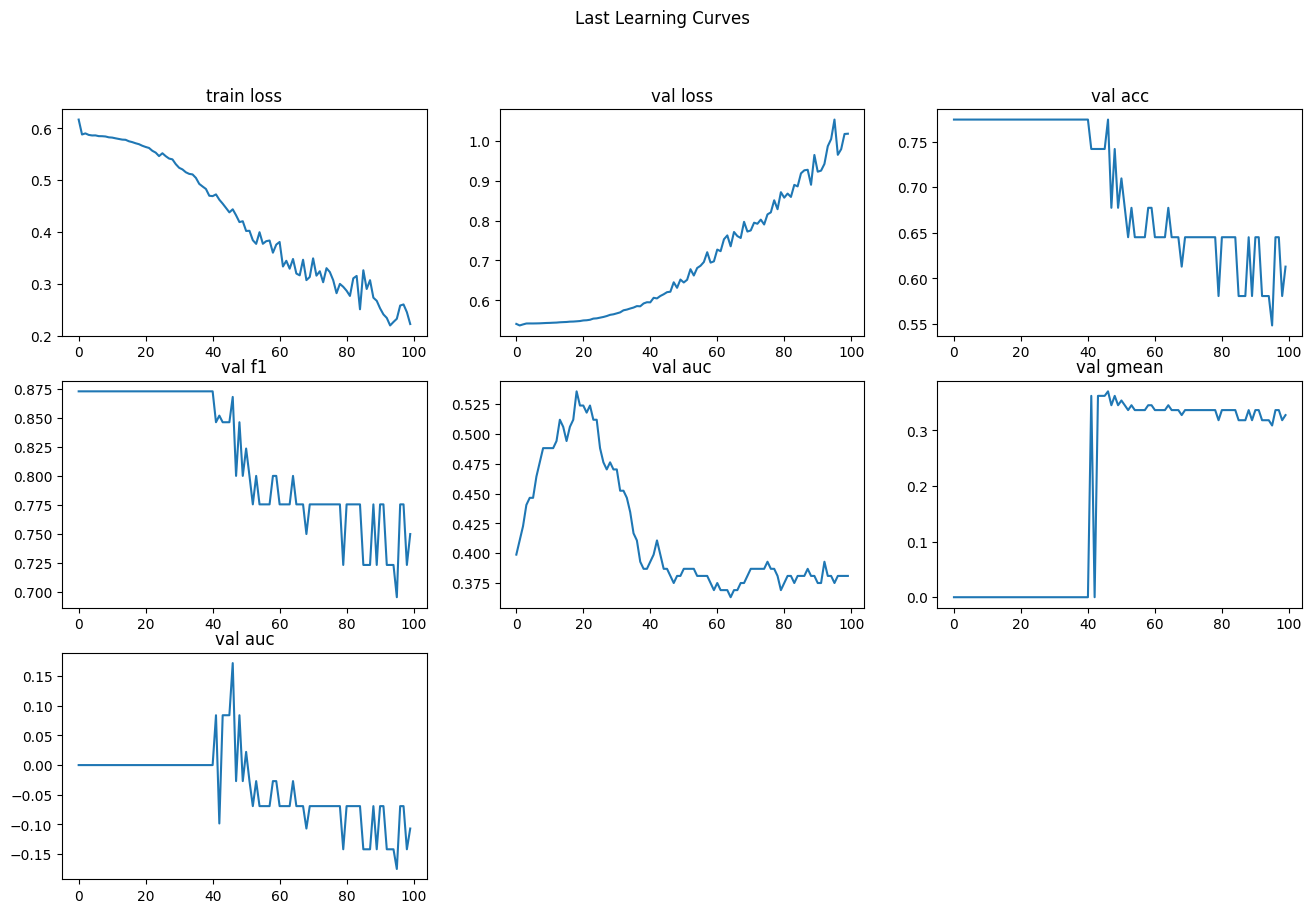

In [21]:
plt.figure(figsize=(16,10))

plt.subplot(331)
plt.plot(loss_buf)
plt.title("train loss")

plt.subplot(332)
plt.plot(val_loss_buf)
plt.title("val loss")

plt.subplot(333)
plt.plot(val_acc_buf)
plt.title("val acc")

plt.subplot(334)
plt.plot(val_f1_buf)
plt.title("val f1")

plt.subplot(335)
plt.plot(val_auc_buf)
plt.title("val auc")

plt.subplot(336)
plt.plot(val_gmean_buf)
plt.title("val gmean")

plt.subplot(337)
plt.plot(val_mcc_buf)
plt.title("val auc")

plt.suptitle("Last Learning Curves")
plt.show()

In [22]:
val_acc_mean = []
val_f1_mean = []
val_auc_mean = []
val_gmean_mean = []
val_mcc_mean = []

for i in range(10):
    
    val_acc_i = np.load("./results/CoV-AbDab/{}/val_acc_{}_best.npy".format(model_name, i))
    val_acc_mean.append(val_acc_i)
    
    val_f1_i = np.load("./results/CoV-AbDab/{}/val_f1_{}_best.npy".format(model_name, i))
    val_f1_mean.append(val_f1_i)
    
    val_auc_i = np.load("./results/CoV-AbDab/{}/val_auc_{}_best.npy".format(model_name, i))
    val_auc_mean.append(val_auc_i)
    
    val_gmean_i = np.load("./results/CoV-AbDab/{}/val_gmean_{}_best.npy".format(model_name, i))
    val_gmean_mean.append(val_gmean_i)
    
    val_mcc_i = np.load("./results/CoV-AbDab/{}/val_mcc_{}_best.npy".format(model_name, i))
    val_mcc_mean.append(val_mcc_i)
    
print("model: {}".format(model_name))
print("val acc mean: ", np.mean(val_acc_mean))
print("val f1 mean: ", np.mean(val_f1_mean))
print("val auc mean: ", np.mean(val_auc_mean))
print("val gmean mean: ", np.mean(val_gmean_mean))
print("val mcc mean: ", np.mean(val_mcc_mean))

model: masonscnn
val acc mean:  0.735483870967742
val f1 mean:  0.8427516133925679
val auc mean:  0.5842978723464658
val gmean mean:  0.0447213595499958
val mcc mean:  0.038299986655989327


In [45]:
use_BSS, model_name

(False, 'SetCoAttnTransformer_ft')

In [ ]:
no L2 pre-trained
use BSS fine-tune
coattn middle


In [ ]:
no L2 pre-trained
use BSS fine-tune
coattn last

only FT pre-trained
model: SetCoAttnTransformer_ft
val acc mean:  0.735483870967742
val f1 mean:  0.8366821293376029
val auc mean:  0.6370810953752131
val gmean mean:  0.14455259003882484
val mcc mean:  0.07770673443679

array([[ 29,  53],
       [ 65, 163]])



all pre-trained
model: SetCoAttnTransformer_ft
val acc mean:  0.7483870967741936
val f1 mean:  0.8396757951718259
val auc mean:  0.6385455337501373
val gmean mean:  0.2422444358382573
val mcc mean:  0.15728803111821626

array([[ 30,  52],
       [ 63, 165]])



no L2 pre-trained
no BSS fine-tune
coattn last

all pre-trained
model: SetCoAttnTransformer_ft
val acc mean:  0.7387096774193549
val f1 mean:  0.8406756060477978
val auc mean:  0.6517170781761574
val gmean mean:  0.20023102380463564
val mcc mean:  0.12508592150070796
    
array([[ 26,  56],
       [ 63, 165]])

In [ ]:
model: SetCoAttnTransformer_ft + BSS
val acc mean:  0.7193548387096775
val f1 mean:  0.8281211639728993
val auc mean:  0.6972362617490495
val gmean mean:  0.15635681579403446
val mcc mean:  0.07797264107266494

array([[ 23,  59],
       [ 58, 170]])


    
model: SetCoAttnTransformer_ft + nonBSS
val acc mean:  0.7258064516129032
val f1 mean:  0.8263352873108616
val auc mean:  0.6545309612240559
val gmean mean:  0.10104200050429028
val mcc mean:  0.04058944141687563
    
array([[ 25,  57],
       [ 73, 155]])

In [ ]:
model: SetCoAttnTransformer_ft (L2 pre-train + fine-tune)
val acc mean:  0.7483870967741936
val f1 mean:  0.8468449123165905
val auc mean:  0.6663944794903874
val gmean mean:  0.2285749110787934
val mcc mean:  0.14789235808005177
    
array([[ 24,  58],
       [ 59, 169]])



model: SetCoAttnTransformer_ft_pairPreTrain

val acc mean:  0.735483870967742
val f1 mean:  0.8428165297819017
val auc mean:  0.5002100840336134
val gmean mean:  0.0
val mcc mean:  0.0
    
array([[  0,  82],
       [  0, 228]])

new dataset: augment negative samples to neg:pos=1:1


new dataset - masonscnn

model: masonscnn
val acc mean:  0.5609756097560976
val f1 mean:  0.7080969748642163
val auc mean:  0.5115618347865623
val gmean mean:  0.1176976534230973
val mcc mean:  0.05414104210725135
    
array([[ 48, 135],
       [ 50, 177]])



new dataset - masonscnn finetune

val acc mean:  0.5560975609756099
val f1 mean:  0.66096776615656
val auc mean:  0.5405112851806215
val gmean mean:  0.45399814531300964
val mcc mean:  0.07182380633434679
    
array([[ 84,  99],
       [ 92, 135]])


new dataset - masonscnn finetune FE Fixed

val acc mean:  0.5414634146341464
val f1 mean:  0.6631533886842206
val auc mean:  0.5499714003821219
val gmean mean:  0.3471025090442392
val mcc mean:  -0.008071772479411338

model: PESI

1. de novo
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8472360344258647
- val auc mean:  0.6364248905399801
- val gmean mean:  0.12137665014671031
- val mcc mean:  0.06637028519834769


- val acc mean:  0.7451612903225807
- val f1 mean:  0.8450983571639433
- val auc mean:  0.5999908666213013
- val gmean mean:  0.1544552971674015
- val mcc mean:  0.0980278804259509

2. fine-tune

fixed Frame/Set feature extractor
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5784537830739878
- val gmean mean:  0.0
- val mcc mean:  0.0

L2 + pre-train
- val acc mean:  0.6129032258064516
- val f1 mean:  0.7267589316962282
- val auc mean:  0.5019817458756078
- val gmean mean:  0.46310214588198306
- val mcc mean:  0.03777970650972913

EnsembleModel1

1. de novo

- val acc mean:  0.7258064516129032
- val f1 mean:  0.8357809829448485
- val auc mean:  0.5863614324010744
- val gmean mean:  0.04364357804719847
- val mcc mean:  -0.00243360941090478


model: EnsembleModel1 (based on DeepAAI hyperparameters)
- val acc mean:  0.735483870967742
- val f1 mean:  0.8426296329094451
- val auc mean:  0.576874495354035
- val gmean mean:  0.026726124191242435
- val mcc mean:  0.016785362070740578


model: EnsembleModel1 (based on DeepAAI hyperparameters) + L2 loss
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.6850925941066606
- val gmean mean:  0.0
- val mcc mean:  0.0


2. finetune

model: EnsembleModel1 (based on DeepAAI hyperparameters) + L2 loss
- val acc mean:  0.7258064516129032
- val f1 mean:  0.8368535348629104
- val auc mean:  0.6183667442248005
- val gmean mean:  0.13486832980505137
- val mcc mean:  0.05979789537418943

EnsembleModel

1. de novo

- val acc mean:  0.7225806451612903
- val f1 mean:  0.80938251651044
- val auc mean:  0.6277278343991899
- val gmean mean:  0.20839957350649357
- val mcc mean:  0.1381022811013694

2. finetune

- val acc mean:  0.7451612903225807
- val f1 mean:  0.8468587022064271
- val auc mean:  0.5173764489275998
- val gmean mean:  0.09929549764864425
- val mcc mean:  0.07493838512158786

MasonsCNN
1. de novo
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5409950281318567

flipping
- val acc mean:  0.735483870967742
- val f1 mean:  0.8427516133925679
- val auc mean:  0.5455146192256166

0209
- val acc mean:  0.732258064516129
- val f1 mean:  0.8411225407108635
- val auc mean:  0.5413395687858604
- val gmean mean:  0.0
- val mcc mean:  -0.003333333333333333

2. finetune
- val acc mean:  0.7193548387096775
- val f1 mean:  0.8280684455906437
- val auc mean:  0.5564490021203576
- val gmean mean:  0.1475625995769564
- val mcc mean:  0.04446577910427487


Feature Extractor fixed
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8338451090661441
- val auc mean:  0.634319673790262
- val gmean mean:  0.24199404771340785
- val mcc mean:  0.12252410865664765

0216
- val acc mean:  0.7322580645161291
- val f1 mean:  0.834695438627144
- val auc mean:  0.6693377090371975
- val gmean mean:  0.2087328313765909
- val mcc mean:  0.11147883124012761

use_pair fine tune 1:1
- val acc mean:  0.5585365853658537
- val f1 mean:  0.6448178293218522
- val auc mean:  0.5488570789936047
- val gmean mean:  0.2955272032441777
- val mcc mean:  0.04813999236891568

use_pair fine tune 1:4
- val acc mean:  0.735483870967742
- val f1 mean:  0.8424975505155541
- val auc mean:  0.5188968581858606
- val gmean mean:  0.04385290096535146
- val mcc mean:  0.024184305584506134

BiLSTM

1. De novo
- val acc mean:  0.7064516129032258
- val f1 mean:  0.819065850000514
- val auc mean:  0.44001247005339084


- val acc mean:  0.7193548387096774
- val f1 mean:  0.8286013119221826
- val auc mean:  0.5272626716846667
- val gmean mean:  0.08176287840460057
- val mcc mean:  0.00657602704451053

2. Finetune - full
- val acc mean:  0.2838709677419355
- val f1 mean:  0.06804597701149426
- val auc mean:  0.524349864826847
- val gmean mean:  0.08231242234049345
- val mcc mean:  -0.003441800331963846

FE Fixed
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5305428632180551
- val gmean mean:  0.0
- val mcc mean:  0.0

0216
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5296878848630767
- val gmean mean:  0.0
- val mcc mean:  0.0


model: lstm_ft_pairPreTrain
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5695255347096778
- val gmean mean:  0.0
- val mcc mean:  0.0

lstm_ft_pairPreTrain 1:4
- val acc mean:  0.735483870967742
- val f1 mean:  0.841992353957726
- val auc mean:  0.44577628992206997
- val gmean mean:  0.05537749241945383
- val mcc mean:  0.029855619650098676

InteractTransformer

1. De novo
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8460928830582551
- val auc mean:  0.5697268280171094

left/right flipping
- val acc mean:  0.6741935483870967
- val f1 mean:  0.7933415428025153
- val auc mean:  0.5941512822216147

0209
- val acc mean:  0.7387096774193548
- val f1 mean:  0.8444456024636061
- val auc mean:  0.5559159858328655
- val gmean mean:  0.0447213595499958
- val mcc mean:  0.04163331998932266

2. Finetune - full
- val acc mean:  0.7387096774193549
- val f1 mean:  0.837479640502948
- val auc mean:  0.5373362548221883
- val gmean mean:  0.11956972115904681
- val mcc mean:  0.05274808166803078

FE Fixed
- val acc mean:  0.7096774193548387
- val f1 mean:  0.8192963769848788
- val auc mean:  0.5437163596562574
- val gmean mean:  0.18894861461152904
- val mcc mean:  0.043908331255973564

InteractCoattnTransformer

1. De novo

coattn after embed
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8384620373723942
- val auc mean:  0.5792465999473672

coattn after transformer
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8389562234502067
- val auc mean:  0.5215266408783032

two coattn
dropout0.3
- val acc mean:  0.6645161290322581
- val f1 mean:  0.7577206864384995
- val auc mean:  0.4894495640761625

dropout0.5
- val acc mean:  0.7032258064516129
- val f1 mean:  0.8148800008196817
- val auc mean:  0.5601084965049159

0209
- val acc mean:  0.7064516129032258
- val f1 mean:  0.8065533962654705
- val auc mean:  0.53074342679202
- val gmean mean:  0.08783456377261516
- val mcc mean:  -0.03089614519177042

0210
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8333675745553654
- val auc mean:  0.5629656307034825
- val gmean mean:  0.19967351371222142
- val mcc mean:  0.08859651752472261

2. Finetune
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8295161019309971
- val auc mean:  0.6776508588030327
- val gmean mean:  0.41048764045233976
- val mcc mean:  0.23726058068617323

0210
- val acc mean:  0.7032258064516129
- val f1 mean:  0.7529802738432863
- val auc mean:  0.5843740140223517
- val gmean mean:  0.11863970769085672
- val mcc mean:  -0.02494321880367

use final model rather than best
- val acc mean:  0.5903225806451613
- val f1 mean:  0.6981662591680293
- val auc mean:  0.5202095768681446
- val gmean mean:  0.43529770732374456
- val mcc mean:  0.035015078636667016

FE Fixed FT
- val acc mean:  0.735483870967742
- val f1 mean:  0.8323679177395693
- val auc mean:  0.5757738855347552
- val gmean mean:  0.1772604277248653
- val mcc mean:  0.051826896161838866

model: InteractCoAttnTransformer_ft_pairPreTrain
- val acc mean:  0.732258064516129
- val f1 mean:  0.8411225407108635
- val auc mean:  0.47004088196543437
- val gmean mean:  0.0
- val mcc mean:  -0.003333333333333333

SetModel
1. de novo

dropout0.3
- val acc mean:  0.7258064516129032
- val f1 mean:  0.8364886835455663
- val auc mean:  0.6504661560377674

dropout0.5 + CoAttnSkipConnection
- val acc mean:  0.7225806451612904
- val f1 mean:  0.7678373423027144
- val auc mean:  0.649160663150433

dropout0.3 + CoAttn ahead
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8331830945361233
- val auc mean:  0.6217202631128462

dropout0.3 + CoAttn ahead + left/right flipping
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8390957431282627
- val auc mean:  0.566890947358978

0209
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8385743405122875
- val auc mean:  0.646844740510981
- val gmean mean:  0.3499641605118257
- val mcc mean:  0.16989948824073764

2. finetune
- val acc mean:  0.6548387096774194
- val f1 mean:  0.7614356955971864
- val auc mean:  0.5850305370957545
- val gmean mean:  0.4690008572794017
- val mcc mean:  0.09590317756829693

FX Fixed FT
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8304804775765957
- val auc mean:  0.6118961087221957
- val gmean mean:  0.325372891932986
- val mcc mean:  0.1376242188288149

SetCoAttnModel

1. de novo
- val acc mean:  0.7129032258064516
- val f1 mean:  0.8283774426716478
- val auc mean:  0.6031828529526739
- val gmean mean:  0.11381713711118394
- val mcc mean:  0.05107581130651245

2. finetune
- val acc mean:  0.735483870967742
- val f1 mean:  0.8255950018544915
- val auc mean:  0.5836535310384415
- val gmean mean:  0.19683955427239194
- val mcc mean:  0.060401168945660236

FE Fixed FT
- val acc mean:  0.7451612903225807
- val f1 mean:  0.840554625019997
- val auc mean:  0.5332801356075013
- val gmean mean:  0.06351073488299558
- val mcc mean:  0.02796710598995068

SetTransformer

1. de novo
- val acc mean:  0.7387096774193549
- val f1 mean:  0.8361401746369017
- val auc mean:  0.6567989579332291
- val gmean mean:  0.22237169691743341
- val mcc mean:  0.11689544381896444

bi-tower
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8304782251291887
- val auc mean:  0.6367931102713712
- val gmean mean:  0.2632115309684307
- val mcc mean:  0.12791443324565496

2. finetune
- val acc mean:  0.7096774193548387
- val f1 mean:  0.8221135340407786
- val auc mean:  0.6275436241791741
- val gmean mean:  0.2348251415923123
- val mcc mean:  0.09602992408332747


FE Fixed FT
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5436637051496387
- val gmean mean:  0.0
- val mcc mean:  0.0

SetCoAttnTransformer

1. de novo
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8371426812951388
- val auc mean:  0.6973226134479332
- val gmean mean:  0.08283199089454711
- val mcc mean:  0.03612682646386498

2. finetune
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8381884843645546
- val auc mean:  0.7171163618989707
- val gmean mean:  0.6158503375322386
- val mcc mean:  0.34239057721353133

- val acc mean:  0.7451612903225807
- val f1 mean:  0.8258364526202552
- val auc mean:  0.667494606842433
- val gmean mean:  0.598600578762371
- val mcc mean:  0.327257546356814

FE Fixed FT
- val acc mean:  0.7387096774193549
- val f1 mean:  0.839985269566902
- val auc mean:  0.641870172027461
- val gmean mean:  0.15255182247968152
- val mcc mean:  0.08206384239742148

model: SetCoAttnTransformer_ft_pairPreTrain
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5
- val gmean mean:  0.0
- val mcc mean:  0.0

InteractTransformerLSTM
1. de novo
- ?

2. finetune
- ?

3. finetune - full
- ?

InteractTransformerLSTM + CoAttn
1. de novo
- ?

FTransformer + CoATtn
1. de novo

1layer + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.48571428571428565

2layers + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.6238095238095238

2layers + kmer3
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.6428571428571429

2layers + kmer4
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.3476190476190476

2layers + kmer3 + lr3e-5
- val acc mean:  0.6451612903225806
- val f1 mean:  0.7755102040816326
- val auc mean:  0.3952380952380952

FTransformer
1. de novo

2layers + kmer3
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.5285714285714286

2layers + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.5619047619047619